In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import sys
from scipy.stats import chi2_contingency
import numpy as np

In [12]:
dir_fig = 'notebook_svs/'

In [2]:
def xfeature(row, biotype):
	ret = 0
	for bio, con in zip(row['BIOTYPE'].split(','), row['Consequence'].split(',')):
		if bio == biotype and 'upstream_gene_variant' not in con and 'downstream_gene_variant' not in con:
			ret = 1
			break
	return ret
    
def xpli(row, pli_thr, gen_list=[]):
	ret = 0
	for p, con in zip(row['GENES_PLI'].split(','), row['Consequence'].split(',')):
		if (p == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(p) >= pli_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
			ret = 1
			break
	return ret

def xlowpli(row, pli_thr, gen_list=[]):
	ret = 1
	for p, con in zip(row['GENES_PLI'].split(','), row['Consequence'].split(',')):
		if (p == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(p) >= pli_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
			ret = 0
			break
	return ret

def xloeuf(row, l_thr, gen_list=[]):
	ret = 0
	for l, con in zip(row['GENES_LOEUF'].split(','), row['Consequence'].split(',')):
		if (l == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(l) <= l_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
			ret = 1
			break
	return ret

def xfdr(row, f_type, f_thr, gen_list=[]):
	ret = 0
	for f, con in zip(row['GENES_FDR_'+f_type].split(','), row['Consequence'].split(',')):
		if (f == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(f) <= f_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
			ret = 1
			break
	return ret

def xfb_pr_enh(row, fb_set):
    ret = 0
    if row['FB_PR_ENH_M'] != '.' and len( set(row['FB_PR_ENH_M'].split('&')).intersection(fb_set) ) != 0:
        ret = 1
    if row['FB_PR_ENH_F'] != '.' and len( set(row['FB_PR_ENH_F'].split('&')).intersection(fb_set) ) != 0:
        ret = 1
    return ret

def xgnocchi(row, gn_thr):
    ret = 0
    if (row['GNOCCHI'] != '.') and (float(row['GNOCCHI']) > gn_thr):
        ret = 1
    return ret

def xfantom(row):
    ret = 0
    if row['FANTOM_ENH'] == 'FanEnh':
        ret = 1
    return ret
                
def status_num(row, cols):
    col_case_nums = []
    col_control_nums = []
    for c in cols:
        col = f'case_{c}'
        if row[col] == '.' or row[col] == '':
            col_case_nums.append(0)
            col_control_nums.append(0)
            continue
        n_case = len([x for x in row[col].split(',') if x == 'Yes'])
        n_control = len([x for x in row[col].split(',') if x == 'No'])
        col_case_nums.append(n_case)
        col_control_nums.append(n_control)
    return *col_case_nums, *col_control_nums
    
def xgencode(row, gen_list, feature):	
	ret = 0
	if row[feature] == 1 and row['GENCODE'] in (gen_list):
		ret = 1
	return ret

def x2features(row, feature1, feature2):
    ret = 0
    if row[feature1] == 1 and row[feature2] == 1:
        ret = 1
    return ret

def count_num(row, col):
    ret = 0
    if row[col] == '.' or row[col] == '':
        return ret
    ret = len(row[col].split(','))
    return ret

def lof(row):
    ret = 0
    if row['SVTYPE'] in ['DEL', 'INS'] and row['GENCODE'] in ['CDS', 'start_codon', 'stop_codon']:
        ret = 1
    if row['LOF_DUP_INV'] == 1:
        ret = 1
    return ret

def xdev_br(row, dev_br_list):
	ret = 0
	for sym, con in zip(row['SYMBOL'].split(','), row['Consequence'].split(',')):
		if (sym == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if sym in dev_br_list:
			ret = 1
			break
	return ret

def get_freq(row, col_lr, parents_set_lr, parents_set_sr):
    # also compute frequency of IL samples in addition to LR col
    if row['PLATFORM'] != 'IL':
        #if row[col_lr] == '.' or row[col_lr] == '':
        #    return 0
        parents = [x for x in row[col_lr].split(',') if x in parents_set_lr]
        freq = float(f'{len(parents) / len(parents_set_lr):.4f}')
        return freq
    else:
        parents = [x for x in (row['HET_SAMPLES'].split(',') + row['HOMALT_SAMPLES'].split(',')) if x in parents_set_sr]
        freq = float(f'{len(parents) / len(parents_set_sr):.4f}')
        return freq

In [3]:
def get_trans(row, col_lr, mom_kids_dict, dad_kids_dict, parent_kids_dict, mate_dict ,aff_dict):
    num_tran_case = 0
    num_tran_control = 0
    num_nontran_case = 0
    num_nontran_control = 0
    if row['PLATFORM'] != 'IL':
        moms = [x for x in row[col_lr].split(',') if x in mom_kids_dict]
        dads = [x for x in row[col_lr].split(',') if x in dad_kids_dict]
        mat_inh = [k for k in row['MAT_INH_LR_LC'].split(',')]
        pat_inh = [k for k in row['PAT_INH_LR_LC'].split(',')]
        ad1_m_ref_samples = row['AD1_M_REF_SAMPLES'].split(',')
        ad1_p_ref_samples = row['AD1_P_REF_SAMPLES'].split(',')
        for mom in moms:
            num_tran_case += len([k for k in mom_kids_dict[mom] if ((k in mat_inh) and (aff_dict[k] == 'Yes'))])
            num_tran_control += len([k for k in mom_kids_dict[mom] if ((k in mat_inh) and (aff_dict[k] == 'No'))])
            num_nontran_case += len([k for k in mom_kids_dict[mom] if ((k not in mat_inh) and (k in ad1_m_ref_samples) and (aff_dict[k] == 'Yes'))])
            num_nontran_control += len([k for k in mom_kids_dict[mom] if ((k not in mat_inh) and (k in ad1_m_ref_samples) and (aff_dict[k] == 'No'))])
        for dad in dads:
            num_tran_case += len([k for k in dad_kids_dict[dad] if ((k in pat_inh) and (aff_dict[k] == 'Yes'))])
            num_tran_control += len([k for k in dad_kids_dict[dad] if ((k in pat_inh) and (aff_dict[k] == 'No'))])
            num_nontran_case += len([k for k in dad_kids_dict[dad] if ((k not in pat_inh) and (k in ad1_p_ref_samples) and (aff_dict[k] == 'Yes'))])
            num_nontran_control += len([k for k in dad_kids_dict[dad] if ((k not in pat_inh) and (k in ad1_p_ref_samples) and (aff_dict[k] == 'No'))])
    else:
        parents = [x for x in row['IL_SAMPLES_LR'].split(',') if x in parent_kids_dict]
        het_samples = [x for x in row['HET_SAMPLES_LR'].split(',')]
        homalt_samples = [x for x in row['HOMALT_SAMPLES_LR'].split(',')]
        samples = het_samples + homalt_samples
        parent_proc = set()
        #tran_kids = [k for k in row['PMAT_INH_IL_LR'].split(',')]
        for parent in parents:
            mate = mate_dict[parent]
            if parent in parent_proc:
                continue
            parent_proc.update([parent, mate])
            if parent in homalt_samples and mate not in parents:
                for k in parent_kids_dict[parent]:
                    if k in het_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 1
                        elif aff_dict[k] == 'No':
                            num_tran_control += 1
            elif parent in homalt_samples and mate in het_samples:
                for k in parent_kids_dict[parent]:
                    if k in het_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 1
                            num_nontran_case += 1
                        elif aff_dict[k] == 'No':
                            num_tran_control += 1
                            num_nontran_control += 1
                    elif k in homalt_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 2
                        elif aff_dict[k] == 'No':
                            num_tran_control += 2
            elif parent in homalt_samples and mate in homalt_samples:
                for k in parent_kids_dict[parent]:
                    if k in homalt_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 2
                        elif aff_dict[k] == 'No':
                            num_tran_control += 2
            elif parent in het_samples and mate not in parents:
                for k in parent_kids_dict[parent]:
                    if k not in samples:
                        if aff_dict[k] == 'Yes':
                            num_nontran_case += 1
                        elif aff_dict[k] == 'No':
                            num_nontran_control += 1
                    elif k in het_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 1
                        elif aff_dict[k] == 'No':
                            num_tran_control += 1
            elif parent in het_samples and mate in het_samples:
                for k in parent_kids_dict[parent]:
                    if k not in samples:
                        if aff_dict[k] == 'Yes':
                            num_nontran_case += 2
                        elif aff_dict[k] == 'No':
                            num_nontran_control += 2
                    elif k in het_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 1
                            num_nontran_case += 1
                        elif aff_dict[k] == 'No':
                            num_tran_control += 1
                            num_nontran_control += 1
                    elif k in homalt_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 2
                        elif aff_dict[k] == 'No':
                            num_tran_control += 2
            elif parent in het_samples and mate in homalt_samples:
                for k in parent_kids_dict[parent]:
                    if k in het_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 1
                            num_nontran_case += 1
                        elif aff_dict[k] == 'No':
                            num_tran_control += 1
                            num_nontran_control += 1
                    elif k in homalt_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 2
                        elif aff_dict[k] == 'No':
                            num_tran_control += 2
    return num_tran_case, num_tran_control, num_nontran_case, num_nontran_control

In [4]:
def get_big_table(file_name):
    df = pd.read_table(file_name, sep='\t', header=0)
    
    main_chroms = [f'chr{x}' for x in range(1,23)] + ['chrX', 'chrY']
    df = pd.DataFrame(df.loc[df.CHROM.isin(main_chroms)])

    print('frequence calc...')
    cols = ['AD2_SAMPLES', 'AD3_SAMPLES', 'AD4_SAMPLES', 'AD5_SAMPLES']
    for col in cols:
        print(f'   {col}')
        df[f'freq_{col}'] = df.apply(lambda row: get_freq(row, col, parents_set_lr, parents_set_sr), axis=1)

    print('count the number of samples in filter columns...')
    cols = ['ZERO_COV_SAMPLES', 'SQ5_SAMPLES', 'SQ10_SAMPLES', 'SQ20_SAMPLES', 'SQ30_SAMPLES', 'SQ40_SAMPLES', 
            'AD2_SAMPLES', 'AD3_SAMPLES', 'AD4_SAMPLES', 'AD5_SAMPLES', 'HET_SAMPLES', 'HOMALT_SAMPLES', 'IL_SAMPLES']
    for col in cols:
        print(col)
        df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)

    print('count number of case/control...')
    cols = ['SQ5_SAMPLES', 'SQ10_SAMPLES', 'SQ20_SAMPLES', 'SQ30_SAMPLES', 'SQ40_SAMPLES', 
            'AD2_SAMPLES', 'AD3_SAMPLES', 'AD4_SAMPLES', 'AD5_SAMPLES', 'HET_SAMPLES', 'HOMALT_SAMPLES', 'IL_SAMPLES']
    df[[f'{col}_CASE_NUM' for col in cols]+[f'{col}_CONTROL_NUM' for col in cols]] = df.apply(lambda row: status_num(row, cols), 
                                                                                                         axis=1, result_type='expand')


    print('IL samples names to LR sample names...')
    rename_IL_to_LR = {'REACH000236_IL': 'REACH000236_PB', 
                       'REACH000436_IL': 'REACH000436_PB', 
                       'REACH000530_IL': 'REACH000530_PB', 
                       'REACH000531_IL': 'REACH000531_ONT', 
                       'REACH000532_IL': 'REACH000532_ONT'}
    df['IL_SAMPLES_LR'] = df.apply(lambda row: ','.join([x if x not in rename_IL_to_LR else rename_IL_to_LR[x] 
                                                         for x in row['IL_SAMPLES'].split(',')]), axis=1)
    df['HET_SAMPLES_LR'] = df.apply(lambda row: ','.join([x if x not in rename_IL_to_LR else rename_IL_to_LR[x] 
                                                         for x in row['HET_SAMPLES'].split(',')]), axis=1)
    df['HOMALT_SAMPLES_LR'] = df.apply(lambda row: ','.join([x if x not in rename_IL_to_LR else rename_IL_to_LR[x] 
                                                         for x in row['HOMALT_SAMPLES'].split(',')]), axis=1)

    print('count number of transmissions...')
    cols = ['AD2_SAMPLES', 'AD3_SAMPLES', 'AD4_SAMPLES', 'AD5_SAMPLES']
    for col in cols:
        print(f'   {col}')
        df[[f'NUM_tran_case_{col}', f'NUM_tran_control_{col}', 
        f'NUM_nontran_case_{col}', f'NUM_nontran_control_{col}']] = df.apply(lambda row: get_trans(row, col, mom_kids_dict, dad_kids_dict, 
                                                                                                   parent_kids_dict, mate_dict, aff_dict), 
                                                                            axis=1, result_type='expand')
    
    biotypes = ['lncRNA' ,'miRNA' ,'misc_RNA' ,'processed_transcript' ,'snoRNA' ,'snRNA' ,'TEC', 'protein_coding']
    for biotype in biotypes:
        print(f'biotype: {biotype}')
        df[f'X_{biotype}'] = df.apply(lambda row: xfeature(row, biotype), axis=1)

    ####################################
    print('protein coding subsets...')
    feature = 'X_protein_coding'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    print('pli...')
    pli_thr = .99
    df['X_PLI'] = df.apply(lambda row: xpli(row, pli_thr), axis=1)

    print('pli >0.9...')
    pli_thr = .9
    df['X_PLIp9'] = df.apply(lambda row: xpli(row, pli_thr), axis=1)

    print('low pli...')
    pli_thr = .9
    df['X_LOWPLI'] = df.apply(lambda row: xlowpli(row, pli_thr), axis=1)

    print('loeuf...')
    l_thr = .37
    #l_thr = .1
    df['X_LOEUF'] = df.apply(lambda row: xloeuf(row, l_thr), axis=1)

    print('ASD...')
    f_thr = .05
    f_type = 'ASD'
    df['X_FDR_ASD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)

    print('DD...')
    f_type = 'DD'
    df['X_FDR_DD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)

    print('NDD...')
    f_type = 'NDD'
    df['X_FDR_NDD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)

    ####################################
    print('pli subsets...')
    feature = 'X_PLI'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('pli >0.9 subsets...')
    feature = 'X_PLIp9'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('low pli subsets...')
    feature = 'X_LOWPLI'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    ####################################
    print('loeuf subsets...')
    feature = 'X_LOEUF'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('ASD subsets...')
    feature = 'X_FDR_ASD'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('DD subsets...')
    feature = 'X_FDR_DD'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('NDD subsets...')
    feature = 'X_FDR_NDD'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    print('LoF...')
    df['LOF'] = df.apply(lambda row: lof(row), axis=1)

    print('LoF constrained subsets...')
    feature1 = 'LOF'
    feature2 = 'X_PLI_cds'
    df['X_LOF_PLI_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_PLIp9_cds'
    df['X_LOF_PLIp9_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_LOWPLI_cds'
    df['X_LOF_LOWPLI_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_LOEUF_cds'
    df['X_LOF_LOEUF_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_ASD_cds'
    df['X_LOF_FDR_ASD_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_DD_cds'
    df['X_LOF_FDR_DD_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_NDD_cds'
    df['X_LOF_FDR_NDD_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    
    print('FB PR...')
    fb_set = set(['1_TssA', '2_TssAFlnk', '10_TssBiv', '11_BivFlnk'])
    df['X_FB_PR'] = df.apply(lambda row: xfb_pr_enh(row, fb_set), axis=1)

    print('FB ENH...')
    fb_set = set(['6_EnhG', '7_Enh', '12_EnhBiv'])
    df['X_FB_ENH'] = df.apply(lambda row: xfb_pr_enh(row, fb_set), axis=1)

    print('FANTOM...')
    df['X_FANTOM'] = df.apply(lambda row: xfantom(row), axis=1)

    gn_thr = 4
    print(f'GNOCCHI_{gn_thr}...')
    df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)

    gn_thr = 3
    print(f'GNOCCHI_{gn_thr}...')
    df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)

    gn_thr = 2
    print(f'GNOCCHI_{gn_thr}...')
    df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)

    gn_thr = 1
    print(f'GNOCCHI_{gn_thr}...')
    df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)

    print('protein_coding CDS subsets...')
    feature1 = 'X_protein_coding_cds'
    feature2 = 'X_PLI'
    df['X_protein_coding_cds_pli'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_LOEUF'
    df['X_protein_coding_cds_loeuf'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_ASD'
    df['X_protein_coding_cds_fdr_asd'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_DD'
    df['X_protein_coding_cds_fdr_dd'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_NDD'
    df['X_protein_coding_cds_fdr_ndd'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)

    print('brain span genes...')
    df['X_DEV_BR_GENE_10'] = df.apply(lambda row: xdev_br(row, br_flt_10), axis=1)
    df['X_DEV_BR_GENE_20'] = df.apply(lambda row: xdev_br(row, br_flt_20), axis=1)
    df['X_DEV_BR_GENE_30'] = df.apply(lambda row: xdev_br(row, br_flt_30), axis=1)
    df['X_DEV_BR_GENE_40'] = df.apply(lambda row: xdev_br(row, br_flt_40), axis=1)
    df['X_DEV_BR_GENE_50'] = df.apply(lambda row: xdev_br(row, br_flt_50), axis=1)

    ####################################
    print('dev brain genes subsets...')
    for rpkm in [10, 20, 30, 40, 50]:
        feature = f'X_DEV_BR_GENE_{rpkm}'
        gen_list = ['CDS', 'start_codon', 'stop_codon']
        df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
        gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
        df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
        gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
        df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    print('LoF dev brain...')
    feature1 = 'LOF'
    for rpkm in [10, 20, 30, 40, 50]:
        feature2 = f'X_DEV_BR_GENE_{rpkm}_cds'
        df[f'X_LOF_DEV_BR_{rpkm}_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)

    print('dev brain and PLI...')
    feature1 = 'X_PLIp9'
    for feature2 in ['LOF_DEV_BR_10_cds', 
                     'DEV_BR_GENE_10', 'DEV_BR_GENE_10_cds', 'DEV_BR_GENE_10_utr', 'DEV_BR_GENE_10_intron']:
        df[f'{feature1}_{feature2}'] = df.apply(lambda row: x2features(row, feature1, f'X_{feature2}'), axis=1)
    
    print('writing the output...')
    df.to_csv('test.tsv', sep='\t', header=True, index=False)
    print('+'*40)
    
    return df, biotypes

In [5]:
file_cov = '/expanse/projects/sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
#file_cov = '/tscc/projects/ps-sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
df_cov = pd.read_table(file_cov, header=0, sep='\t')
multiplat_samples = ['REACH000236', 'REACH000530', 'REACH000531', 'REACH000532', 'REACH000436']
df_cov['SAMPLE'] = df_cov.apply(lambda row: row['SAMPLE']+'_'+row['COHORT'] if row['SAMPLE'] in multiplat_samples else row['SAMPLE'], axis=1)
df_cov_high = df_cov.loc[df_cov.SAMPLE.str.startswith('REACH000') & (df_cov.MEAN_COVERAGE > 9)]
display(df_cov)
high_cov_samples = df_cov_high.SAMPLE.tolist()
#print(high_cov_samples)

def get_plat(sample):
    try:
        ret = df_cov[df_cov.SAMPLE == sample]['COHORT'].values[0]
    except:
        print(f'problem with samples: {sample}')
        ret = ''
    return ret

plat_dict = {sample: get_plat(sample) for sample in df_cov.SAMPLE.tolist()}

#this_sample = 'REACH000520'
#this_sample = 'REACH000290'
#this_sample = 'REACH000236_PB'
#print(df_cov[df_cov.SAMPLE == this_sample]['COHORT'].values)
#this_plat = get_plat(this_sample)
#print(this_plat)
#print(df_cov)

,SAMPLE,COHORT,MEAN_COVERAGE
0,HG004,ONT,81.44
1,REACH000626,ONT,10.51
2,REACH000546,ONT,10.87
3,REACH000683,ONT,9.97
4,REACH000563,ONT,8.68
...,...,...,...
283,REACH000284,PB,3.43
284,REACH000672,PB,5.02
285,REACH000292,PB,9.00
286,REACH000066,PB,1.61


In [6]:
file_brainspan = '/expanse/projects/sebat1/miladm/UCSD/resources/brainspan_rnaseq/process/gene_list_RPKM_10.csv'
dtype = {'gene_id': str, 'entrez_id': str}
df_br = pd.read_table(file_brainspan, sep=',', header=0, dtype=dtype)
br_flt_10 = df_br.loc[df_br.mean_rpkm>10].gene_symbol.tolist()
br_flt_20 = df_br.loc[df_br.mean_rpkm>20].gene_symbol.tolist()
br_flt_30 = df_br.loc[df_br.mean_rpkm>30].gene_symbol.tolist()
br_flt_40 = df_br.loc[df_br.mean_rpkm>40].gene_symbol.tolist()
br_flt_50 = df_br.loc[df_br.mean_rpkm>50].gene_symbol.tolist()
print(df_br.shape)
print(len(br_flt_10))
print(len(br_flt_20))
print(len(br_flt_30))
print(len(br_flt_40))
print(len(br_flt_50))

(5824, 32)
5824
3045
1983
1392
1078


In [7]:
file_psam = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/process_IL_LR/HWE/REACH_LR_platform.psam'
df_p = pd.read_table(file_psam, sep='\t', header=None, names = ['famid', 'sample_id', 'dad', 'mom', 'sex', 'phen'])
display(df_p)

# make mom and dad dictionary
sample_dad_dict = {}
sample_mom_dict = {}
for sample, dad, mom in zip(df_p.sample_id, df_p.dad, df_p.mom):
    #print(sample, dad, mom)
    sample_dad_dict[sample] = dad
    sample_mom_dict[sample] = mom

print('complete trios:')
df_trios = df_p.loc[df_p.dad.isin(df_p.sample_id) & df_p.mom.isin(df_p.sample_id)]
display(df_trios)
print(df_trios.sex.value_counts())
print(df_trios.phen.value_counts())

parents_set_lr = set(df_trios.dad.tolist()) | set(df_trios.mom.tolist())
print(f'len(parents_set_lr): {len(parents_set_lr)}')
print(parents_set_lr)

rename_samples_dict_IL = {'REACH000236_PB': 'REACH000236_IL', 
                          'REACH000436_PB': 'REACH000436_IL', 
                          'REACH000530_PB': 'REACH000530_IL', 
                          'REACH000531_ONT': 'REACH000531_IL', 
                          'REACH000532_ONT': 'REACH000532_IL'}
parents_set_sr = {x if x not in rename_samples_dict_IL else rename_samples_dict_IL[x] for x in parents_set_lr}
print(f'len(parents_set_sr): {len(parents_set_sr)}')
print(parents_set_sr)

parent_kids_dict = {}
mom_kids_dict = {}
dad_kids_dict = {}
for parent in parents_set_lr:
    parent_kids_dict[parent] = df_trios.loc[(df_trios.dad == parent) | (df_trios.mom == parent)].sample_id.tolist()
    if parent in df_trios.dad.tolist():
        dad_kids_dict[parent] = df_trios.loc[(df_trios.dad == parent)].sample_id.tolist()
    if parent in df_trios.mom.tolist():
        mom_kids_dict[parent] = df_trios.loc[(df_trios.mom == parent)].sample_id.tolist()
print(f'len(parent_kids_dict): {len(parent_kids_dict)}')
print(parent_kids_dict)
print(f'len(mom_kids_dict): {len(mom_kids_dict)}')
print(mom_kids_dict)
print(f'len(dad_kids_dict): {len(dad_kids_dict)}')
print(dad_kids_dict)

mate_dict = {}
for dad, mom in zip(df_trios.dad, df_trios.mom):
    mate_dict[dad] = mom
    mate_dict[mom] = dad
print(f'len(mate_dict): {len(mate_dict)}')
print(mate_dict)

,famid,sample_id,dad,mom,sex,phen
0,2323,2323-2-1,0,0,2,2
1,2602,2602-2-1,0,0,2,2
2,3392,3392-2-3,0,0,2,2
3,3538,3538-2-1,0,0,2,2
4,3939,3939-3-1,0,0,2,2
...,...,...,...,...,...,...
275,F0270,REACH000681,REACH000683,REACH000682,1,2
276,F0270,REACH000682,0,0,2,2
277,F0270,REACH000683,0,0,1,2
278,F0270,REACH000684,REACH000683,REACH000682,1,2


complete trios:


,famid,sample_id,dad,mom,sex,phen
10,F0026,REACH000026,REACH000270,REACH000269,1,2
11,F0058,REACH000058,REACH000440,REACH000439,1,2
12,F0065,REACH000065,REACH000067,REACH000066,1,2
15,F0078,REACH000086,REACH000088,REACH000087,1,2
18,F0078,REACH000089,REACH000088,REACH000087,2,2
...,...,...,...,...,...,...
271,F0266,REACH000660,REACH000662,REACH000661,2,2
274,F0266,REACH000663,REACH000662,REACH000661,1,1
275,F0270,REACH000681,REACH000683,REACH000682,1,2
278,F0270,REACH000684,REACH000683,REACH000682,1,2


sex
1    74
2    43
Name: count, dtype: int64
phen
2    92
1    25
Name: count, dtype: int64
len(parents_set_lr): 126
{'REACH000267', 'REACH000421', 'REACH000424', 'REACH000315', 'REACH000628', 'REACH000415', 'REACH000477', 'REACH000557', 'REACH000088', 'REACH000756', 'REACH000098', 'REACH000511', 'REACH000437', 'REACH000314', 'REACH000436_PB', 'REACH000286', 'REACH000539', 'REACH000749', 'REACH000764', 'REACH000401', 'REACH000645', 'REACH000480', 'REACH000580', 'REACH000099', 'REACH000707', 'REACH000516', 'REACH000682', 'REACH000155', 'REACH000411', 'REACH000248', 'REACH000093', 'REACH000604', 'REACH000753', 'REACH000763', 'REACH000442', 'REACH000184', 'REACH000673', 'REACH000226', 'REACH000416', 'REACH000524', 'REACH000565', 'REACH000247', 'REACH000515', 'REACH000683', 'REACH000221', 'REACH000562', 'REACH000425', 'REACH000478', 'REACH000234', 'REACH000603', 'REACH000094', 'REACH000087', 'REACH000531_ONT', 'REACH000122', 'REACH000512', 'REACH000651', 'REACH000220', 'REACH000703', 'REA

In [8]:
meta_file = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/REACH_sample_info.tsv'
df_meta = pd.read_table(meta_file, sep='\t', header=0)

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
df_meta['Sample_ID'] = df_meta.apply(lambda row: rename_samples_dict[row['Sample_ID']] 
                                     if row['Sample_ID'] in rename_samples_dict else row['Sample_ID'], axis=1)
display(df_meta)
#df_meta_flt = df_meta.loc[df_meta.Sample_ID.isin(df_trios.sample_id)]
#display(df_meta_flt)

#print(df_meta_flt.Affected.value_counts())

aff_dict = {}
for sample, aff in zip(df_meta['Sample_ID'].tolist(), df_meta['Affected'].tolist()):
    aff_dict[sample] = aff 

,Sample_ID,Subject_ID,Family_ID,DOB,Family_Type,Affected,Diagnosis_LAB,Mother_ID,Father_ID,Rel_Proband,...,Blood Box,Sample Source,Date sent for DNA extraction,Location of DNA extraction,DNA Box,Concentration (ng/uL),260/280,Date sent for Sequencing,WGS Provider,(Sample Well) Plate Name.Sample.ID
0,REACH000001,F0001-01,F0001,3/26/2007,trio,Yes,Autism,F0001-02,F0001-03,Proband,...,1,Sebat,Unknown,Gleeson,1,60.0,1.80,9/9/2013,Illumina,LP6005688-DNA_E11
1,REACH000107,F0001-02,F0001,8/9/1972,trio,Yes,Autism,Unknown,Unknown,Mom,...,2,Sebat,Unknown,Gleeson,2,60.0,NaN,9/9/2013,Illumina,LP6005688-DNA_F11
2,REACH000226,F0001-03,F0001,9/27/1969,trio,Yes,"Autism, PTSD, ADHD",Unknown,Unknown,Dad,...,3,Sebat,Unknown,Gleeson,3,60.0,NaN,9/9/2013,Illumina,LP6005688-DNA_G11
3,REACH000002,F0002-01,F0002,11/19/2007,incomplete,Yes,Autism,Unknown,Unknown,Proband,...,1,Sebat,Unknown,Gleeson,1,Incomplete,Incomplete,Incomplete family,Incomplete family,Incomplete family
4,REACH000003,F0003-01,F0003,8/9/2000,incomplete,Yes,Autism,Unknown,Unknown,Proband,...,1,Sebat,Unknown,Gleeson,1,Incomplete,Incomplete,Incomplete family,Incomplete family,Incomplete family
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,REACH000889,F0320-02,F0320,1/15/1981,multiple,No,"Crohn's Disease, Lupus (SLE)",F8888-88,F8888-88,Mom,...,11,Sebat,2/28/2017,Sebat,11,36.2,1.79,pending,pending,pending
889,REACH000890,F0320-03,F0320,7/9/1980,multiple,No,NaN,F8888-88,F8888-88,Dad,...,11,Sebat,2/28/2017,Sebat,11,41.9,1.84,pending,pending,pending
890,REACH000891,F0320-04,F0320,2/26/2010,multiple,No,NaN,F0320-02,F0320-03,Sibling,...,11,Sebat,2/28/2017,Sebat,11,119.7,1.84,pending,pending,pending
891,REACH000892,F0320-05,F0320,10/14/2011,multiple,No,NaN,F0320-02,F0320-03,Sibling,...,12,Sebat,2/28/2017,Sebat,12,134.1,1.85,pending,pending,pending


In [9]:
#file_pca = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/PCA/kid_pca_info.csv'
#file_pca = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/PCA/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20210915.csv'
file_pca = '/expanse/projects/sebat1/j3guevar/SFARI/aspera-sf/SFARI_DS468588/data/master_phen_4.SBayesR.20210915.csv'

df_pca = pd.read_table(file_pca, sep=',', header=0)
cols = ['fid', 'iid', 'phen','sex','cohort','duo','family','is_eur','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10', 
        'PC1_PAT','PC2_PAT','PC3_PAT','PC4_PAT','PC5_PAT','PC6_PAT','PC7_PAT','PC8_PAT','PC9_PAT','PC10_PAT', 
        'PC1_MAT','PC2_MAT','PC3_MAT','PC4_MAT','PC5_MAT','PC6_MAT','PC7_MAT','PC8_MAT','PC9_MAT','PC10_MAT']
df_pca = df_pca[cols]

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
df_pca['iid'] = df_pca.apply(lambda row: rename_samples_dict[row['iid']] if row['iid'] in rename_samples_dict else row['iid'], axis=1)
#display(df_pca)

# first filter for the kids, then add parents to them
df_pca_flt = df_pca.loc[df_pca.iid.isin(df_trios.sample_id)]
print('df_pca_flt:')
display(df_pca_flt)

df_parents = pd.DataFrame()
for index, row in df_pca_flt.iterrows():
    sample = row['iid']
    fid = row['fid']
    phen = row['phen']
    is_eur = row['is_eur']
    pc_mat = [row[f'PC{x}_MAT'] for x in range(1,11)]
    pc_pat = [row[f'PC{x}_PAT'] for x in range(1,11)]
    dad = sample_dad_dict[sample]
    mom = sample_mom_dict[sample]
    
    dict_mat = {'fid': [fid], 'iid': [mom], 'phen': ['.'], 'sex': ['Female'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_mat.update({f'PC{x}': [pc_mat[x-1]] for x in range(1,11)})
    df_mat = pd.DataFrame(dict_mat)

    dict_pat = {'fid': [fid], 'iid': [dad], 'phen': ['.'], 'sex': ['Male'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_pat.update({f'PC{x}': [pc_pat[x-1]] for x in range(1,11)})
    df_pat = pd.DataFrame(dict_pat)
    
    if df_parents.shape[0] == 0 or mom not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_mat])
    if df_parents.shape[0] == 0 or dad not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_pat])

#display(df_pca_flt)
print('df_parents:')
display(df_parents)

df_pca_flt = pd.concat([df_pca_flt, df_parents])
print('df_pca_flt:')
display(df_pca_flt)

df_pca_flt = pd.merge(df_pca_flt, df_meta[['Sample_ID', 'Affected']], how='inner', left_on='iid', right_on='Sample_ID')
df_pca_flt = pd.merge(df_pca_flt, df_cov[['SAMPLE', 'MEAN_COVERAGE']], how='inner', left_on='iid', right_on='SAMPLE')

df_pca_flt['Phenotype'] = df_pca_flt.apply(lambda row: 1 if row.Affected == 'Yes' else 0, axis=1)
df_pca_flt['Platform'] = df_pca_flt.apply(lambda row: get_plat(row.iid), axis=1)
display(df_pca_flt)

print(df_pca_flt.sex.value_counts())
print(df_pca_flt.Phenotype.value_counts())
print(df_pca_flt.Affected.value_counts())
print(df_pca_flt.Platform.value_counts())

df_pca_flt:


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,PC1_MAT,PC2_MAT,PC3_MAT,PC4_MAT,PC5_MAT,PC6_MAT,PC7_MAT,PC8_MAT,PC9_MAT,PC10_MAT
136,F0001,REACH000001,ASD,Male,1,trio,1,1,0.008627,-0.005607,...,-0.022403,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983
137,F0026,REACH000026,ASD,Male,1,trio,1,0,0.095364,-0.045230,...,0.100551,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925
139,F0058,REACH000058,ASD,Male,1,trio,1,1,0.002422,-0.009216,...,-0.025327,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383
140,F0065,REACH000065,ASD,Male,1,trio,1,0,0.252774,0.107933,...,0.243117,0.049799,0.158347,0.011411,0.004728,0.007690,-0.006605,0.008261,-0.012000,-0.009906
146,F0078,REACH000086,ASD,Male,1,trio,2,0,0.044785,0.038065,...,0.129968,0.080387,0.132056,0.029583,0.020156,0.007971,-0.002383,0.014468,0.006253,-0.018303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,F0290,REACH000762,ASD,Male,1,trio,1,1,-0.027901,0.000946,...,-0.030630,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684
409,F0290,REACH000765,CON,Female,1,trio,1,1,-0.030809,-0.001867,...,-0.030630,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684
410,F0290,REACH000766,CON,Female,1,trio,1,1,-0.028469,-0.005167,...,-0.030630,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684
411,F0291,REACH000767,ASD,Male,1,trio,1,0,0.087690,-0.012273,...,0.091442,-0.016917,-0.021358,0.151522,-0.035297,0.008383,0.005679,0.020179,-0.022316,0.002755


df_parents:


,fid,iid,phen,sex,cohort,duo,is_eur,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,F0001,REACH000107,.,Female,1,.,1,-0.022403,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983
0,F0001,REACH000226,.,Male,1,.,1,0.024023,-0.013482,-0.003936,0.129597,0.030587,-0.007727,-0.002212,-0.022159,0.005150,-0.000824
0,F0026,REACH000269,.,Female,1,.,0,0.100551,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925
0,F0026,REACH000270,.,Male,1,.,0,0.091671,-0.037847,-0.022134,0.163193,0.007864,-0.006841,-0.023716,0.040800,0.006666,-0.012916
0,F0058,REACH000439,.,Female,1,.,1,-0.025327,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,F0288,REACH000756,.,Male,1,.,0,0.204041,0.127559,0.190286,0.013553,0.006706,-0.001266,-0.010150,0.006605,-0.006867,0.006560
0,F0290,REACH000763,.,Female,1,.,1,-0.030630,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684
0,F0290,REACH000764,.,Male,1,.,1,-0.027327,-0.004878,-0.003881,0.000495,0.003727,-0.001647,-0.008831,0.016730,-0.005315,0.006958
0,F0291,REACH000768,.,Female,1,.,0,0.091442,-0.016917,-0.021358,0.151522,-0.035297,0.008383,0.005679,0.020179,-0.022316,0.002755


df_pca_flt:


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,PC1_MAT,PC2_MAT,PC3_MAT,PC4_MAT,PC5_MAT,PC6_MAT,PC7_MAT,PC8_MAT,PC9_MAT,PC10_MAT
136,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,-0.022403,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983
137,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,0.100551,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925
139,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,-0.025327,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383
140,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,0.243117,0.049799,0.158347,0.011411,0.004728,0.007690,-0.006605,0.008261,-0.012000,-0.009906
146,F0078,REACH000086,ASD,Male,1,trio,2.0,0,0.044785,0.038065,...,0.129968,0.080387,0.132056,0.029583,0.020156,0.007971,-0.002383,0.014468,0.006253,-0.018303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,F0288,REACH000756,.,Male,1,.,NaN,0,0.204041,0.127559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,F0290,REACH000763,.,Female,1,.,NaN,1,-0.030630,0.003052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,F0290,REACH000764,.,Male,1,.,NaN,1,-0.027327,-0.004878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,F0291,REACH000768,.,Female,1,.,NaN,0,0.091442,-0.016917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,PC7_MAT,PC8_MAT,PC9_MAT,PC10_MAT,Sample_ID,Affected,SAMPLE,MEAN_COVERAGE,Phenotype,Platform
0,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,0.007249,0.002096,0.005399,-0.014983,REACH000001,Yes,REACH000001,10.15,1,ONT
1,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,-0.020773,0.034190,0.015895,-0.011925,REACH000026,Yes,REACH000026,3.22,1,PB
2,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,0.032103,0.009510,0.020007,0.016383,REACH000058,Yes,REACH000058,6.19,1,PB
3,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,-0.006605,0.008261,-0.012000,-0.009906,REACH000065,Yes,REACH000065,1.22,1,PB
4,F0078,REACH000086,ASD,Male,1,trio,2.0,0,0.044785,0.038065,...,-0.002383,0.014468,0.006253,-0.018303,REACH000086,Yes,REACH000086,2.70,1,PB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,F0288,REACH000756,.,Male,1,.,NaN,0,0.204041,0.127559,...,NaN,NaN,NaN,NaN,REACH000756,No,REACH000756,1.55,0,PB
239,F0290,REACH000763,.,Female,1,.,NaN,1,-0.030630,0.003052,...,NaN,NaN,NaN,NaN,REACH000763,No,REACH000763,3.36,0,PB
240,F0290,REACH000764,.,Male,1,.,NaN,1,-0.027327,-0.004878,...,NaN,NaN,NaN,NaN,REACH000764,No,REACH000764,1.20,0,PB
241,F0291,REACH000768,.,Female,1,.,NaN,0,0.091442,-0.016917,...,NaN,NaN,NaN,NaN,REACH000768,No,REACH000768,0.10,0,PB


sex
Male      137
Female    106
Name: count, dtype: int64
Phenotype
1    133
0    110
Name: count, dtype: int64
Affected
Yes    133
No     110
Name: count, dtype: int64
Platform
PB     142
ONT    101
Name: count, dtype: int64


notebook_svs/PC1_vs_PC2.png


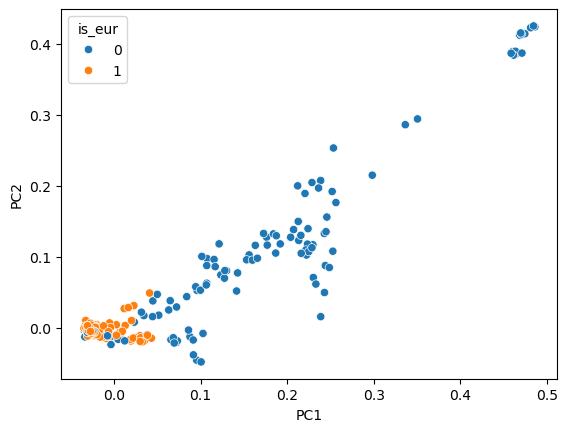

In [14]:
import seaborn as sb

plt.figure()
sb.scatterplot(data=df_pca_flt, x='PC1', y='PC2', hue='is_eur')
fig_name = dir_fig + 'PC1_vs_PC2.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()

In [11]:
#########################################
# generate the big table
#file_name = 'combined_table.chr22.tsv'
file_name = 'combined_table.tsv'
df, biotypes = get_big_table(file_name)
#display(df)

# or read the big table
#file_name = 'test.tsv'
#df = pd.read_table(file_name, sep='\t', header=0)
#########################################

/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:2: DtypeWarning: Columns (25,59,60,64,66,67,71,72,73,74,75,76,77,78,82,83,84,85,86,87,88,89,93,94,95,96,97,98,99,100,104,105,106,107,108,109,110,111,115,116,117,118,119,120,121,122) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(file_name, sep='\t', header=0)


frequence calc...
   AD2_SAMPLES
   AD3_SAMPLES
   AD4_SAMPLES
   AD5_SAMPLES
count the number of samples in filter columns...
ZERO_COV_SAMPLES
SQ5_SAMPLES
SQ10_SAMPLES
SQ20_SAMPLES
SQ30_SAMPLES
SQ40_SAMPLES
AD2_SAMPLES
AD3_SAMPLES
AD4_SAMPLES
AD5_SAMPLES
HET_SAMPLES
HOMALT_SAMPLES
IL_SAMPLES
count number of case/control...
IL samples names to LR sample names...
count number of transmissions...
   AD2_SAMPLES
   AD3_SAMPLES
   AD4_SAMPLES
   AD5_SAMPLES
biotype: lncRNA
biotype: miRNA
biotype: misc_RNA
biotype: processed_transcript
biotype: snoRNA
biotype: snRNA
biotype: TEC
biotype: protein_coding
protein coding subsets...
pli...
low pli...
loeuf...
ASD...
DD...
NDD...
pli subsets...
pli >0.9 subsets...
low pli subsets...
loeuf subsets...
ASD subsets...
DD subsets...
NDD subsets...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:178: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)


LoF...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:181: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['LOF'] = df.apply(lambda row: lof(row), axis=1)


LoF constrained subsets...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_LOF_PLI_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_LOF_PLIp9_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:190: PerformanceWarning: DataFrame is highly fragmented.

FB PR...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_FB_PR'] = df.apply(lambda row: xfb_pr_enh(row, fb_set), axis=1)


FB ENH...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:206: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_FB_ENH'] = df.apply(lambda row: xfb_pr_enh(row, fb_set), axis=1)


FANTOM...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_FANTOM'] = df.apply(lambda row: xfantom(row), axis=1)


GNOCCHI_4...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:213: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)


GNOCCHI_3...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:217: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)


GNOCCHI_2...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:221: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)


GNOCCHI_1...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:225: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)


protein_coding CDS subsets...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:230: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_protein_coding_cds_pli'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:232: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_protein_coding_cds_loeuf'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:234: PerformanceWarning: DataFrame

brain span genes...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:241: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_DEV_BR_GENE_10'] = df.apply(lambda row: xdev_br(row, br_flt_10), axis=1)
/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:242: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_DEV_BR_GENE_20'] = df.apply(lambda row: xdev_br(row, br_flt_20), axis=1)
/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

dev brain genes subsets...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:255: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:258: PerformanceWarning: DataFrame is highly fragmented.  This

LoF dev brain...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:264: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'X_LOF_DEV_BR_{rpkm}_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:264: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'X_LOF_DEV_BR_{rpkm}_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:264: PerformanceWarning: DataFrame i

dev brain and PLI...


/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:270: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature1}_{feature2}'] = df.apply(lambda row: x2features(row, feature1, f'X_{feature2}'), axis=1)
/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:270: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature1}_{feature2}'] = df.apply(lambda row: x2features(row, feature1, f'X_{feature2}'), axis=1)
/scratch/smmortazavi/job_31437492/ipykernel_2509515/3878243983.py:270: PerformanceWarning: D

writing the output...
++++++++++++++++++++++++++++++++++++++++


In [15]:
def get_df_flt(df, flt_name, svtypes, ext_col=None, flt_sd_art=True, freq_thr=1):
    if not ext_col:
        df_flt = df.loc[((df[f'NUM_{flt_name}'] > 0) | (df['NUM_IL_SAMPLES'] > 0)) & (df.SVTYPE.isin(svtypes))]
    else:
        df_flt = df.loc[((df[f'NUM_{flt_name}'] > 0) | (df['NUM_IL_SAMPLES'] > 0)) & (df.SVTYPE.isin(svtypes)) & (df[ext_col]==1)]
    if flt_sd_art:
        df_flt = df_flt.loc[~((df_flt.SD_ART==1) & (df_flt.PLATFORM=='LR'))]
    df_flt = df_flt.loc[df_flt[f'freq_{flt_name}']<=freq_thr]
    return df_flt

In [16]:
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

total: (344736, 298)
filtered: (43240, 298)
total: (344736, 298)
filtered: (27669, 298)


In [17]:
biotypes = ['lncRNA' ,'miRNA' ,'misc_RNA' ,'processed_transcript' ,'snoRNA' ,'snRNA' ,'TEC', 'protein_coding']
pc_subsec = ['protein_coding_cds', 'protein_coding_utr', 'protein_coding_intron', 
             'protein_coding_cds_pli', 'protein_coding_cds_loeuf', 
             'protein_coding_cds_fdr_asd', 'protein_coding_cds_fdr_dd', 'protein_coding_cds_fdr_ndd']
consts_1 = ['PLI', 'LOEUF', 'FDR_ASD', 'FDR_DD', 'FDR_NDD']
consts_2 = ['FB_PR', 'FB_ENH', 'FANTOM', 'GNOCCHI_1', 'GNOCCHI_2', 'GNOCCHI_3', 'GNOCCHI_4']
consts_subsec_1 = ['PLI_cds', 'PLI_utr', 'PLI_intron', 
                   'LOEUF_cds', 'LOEUF_utr', 'LOEUF_intron']
consts_subsec_2 = ['FDR_ASD_cds', 'FDR_ASD_utr', 'FDR_ASD_intron', 
                   'FDR_DD_cds', 'FDR_DD_utr', 'FDR_DD_intron', 
                   'FDR_NDD_cds', 'FDR_NDD_utr', 'FDR_NDD_intron']
consts_subsec_3 = ['PLIp9_cds', 'PLIp9_utr', 'PLIp9_intron',
                   'LOWPLI_cds', 'LOWPLI_utr', 'LOWPLI_intron']
dev_br_10 = ['DEV_BR_GENE_10', 'DEV_BR_GENE_10_cds', 'DEV_BR_GENE_10_utr', 'DEV_BR_GENE_10_intron']
dev_br_20 = ['DEV_BR_GENE_20', 'DEV_BR_GENE_20_cds', 'DEV_BR_GENE_20_utr', 'DEV_BR_GENE_20_intron']
dev_br_30 = ['DEV_BR_GENE_30', 'DEV_BR_GENE_30_cds', 'DEV_BR_GENE_30_utr', 'DEV_BR_GENE_30_intron']
dev_br_40 = ['DEV_BR_GENE_40', 'DEV_BR_GENE_40_cds', 'DEV_BR_GENE_40_utr', 'DEV_BR_GENE_40_intron']
dev_br_50 = ['DEV_BR_GENE_50', 'DEV_BR_GENE_50_cds', 'DEV_BR_GENE_50_utr', 'DEV_BR_GENE_50_intron']
lof_dev_br = ['LOF_DEV_BR_50_cds', 'LOF_DEV_BR_40_cds', 'LOF_DEV_BR_30_cds', 'LOF_DEV_BR_20_cds', 'LOF_DEV_BR_10_cds']
lof_plus_consts = ['LOF_DEV_BR_10_cds', 'LOF_PLI_cds', 'PLI_cds', 'PLI_utr', 'PLI_intron',
                   'LOF_LOEUF_cds', 'LOEUF_cds', 'LOEUF_utr', 'LOEUF_intron']
lof_plus_consts2 = ['LOF_DEV_BR_10_cds', 'LOF_PLI_cds', 'PLI_cds', 'PLI_utr', 'PLI_intron',
                   'LOF_LOWPLI_cds',  'LOWPLI_cds', 'LOWPLI_utr', 'LOWPLI_intron']
lof_plus_consts3 = ['LOF_PLIp9_cds', 'PLIp9_cds', 'PLIp9_utr', 'PLIp9_intron']
lof_plus_consts4 = ['LOF_FDR_ASD_cds', 'LOF_FDR_DD_cds', 'LOF_FDR_NDD_cds']
lof_plus_consts5 = ['PLIp9_LOF_DEV_BR_10_cds', 
                    'PLIp9_DEV_BR_GENE_10', 
                    'PLIp9_DEV_BR_GENE_10_cds', 'PLIp9_DEV_BR_GENE_10_utr', 'PLIp9_DEV_BR_GENE_10_intron']

In [18]:
### write counts for each sample for R script

fts = (biotypes + pc_subsec + consts_1 + consts_2 + consts_subsec_1 + consts_subsec_2 + 
       dev_br_10 + dev_br_20 + dev_br_30 + dev_br_40 + dev_br_50 + lof_dev_br + 
       lof_plus_consts + lof_plus_consts2 + lof_plus_consts3 + lof_plus_consts4 + lof_plus_consts5)

flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

samples_col = 'AD2_SAMPLES'
#samples_col = 'AD3_SAMPLES'
df_main = pd.DataFrame(df_pca_flt)
for ft in fts:
    #print(ft)
    this_df = df_flt.loc[df_flt[f'X_{ft}'] == 1]
    temp = this_df[samples_col].str.split(',').tolist() + this_df['IL_SAMPLES_LR'].str.split(',').tolist()
    this_samples_list = []
    for x in temp:
        this_samples_list.extend(x)
    count_col = []
    for sample in df_pca_flt.iid.tolist():
        count_col.append(this_samples_list.count(sample))
    df_main[f'count_{ft}'] = count_col

display(df_main)
file_out = 'main_df_toR_freq05_LRIL.csv'
print(f'writing {file_out}')
df_main.to_csv(file_out, sep=',', header=True, index=False)
print('+'*40)

total: (344736, 298)
filtered: (27669, 298)


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,count_PLIp9_utr,count_PLIp9_intron,count_LOF_FDR_ASD_cds,count_LOF_FDR_DD_cds,count_LOF_FDR_NDD_cds,count_PLIp9_LOF_DEV_BR_10_cds,count_PLIp9_DEV_BR_GENE_10,count_PLIp9_DEV_BR_GENE_10_cds,count_PLIp9_DEV_BR_GENE_10_utr,count_PLIp9_DEV_BR_GENE_10_intron
0,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,1,94,0,0,0,1,37,2,0,35
1,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,0,57,0,0,0,0,14,0,0,14
2,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,2,44,0,0,0,0,19,0,0,19
3,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,0,40,0,0,0,1,14,1,0,13
4,F0078,REACH000086,ASD,Male,1,trio,2.0,0,0.044785,0.038065,...,1,43,0,0,0,0,21,0,1,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,F0288,REACH000756,.,Male,1,.,NaN,0,0.204041,0.127559,...,1,28,0,0,0,0,10,0,1,9
239,F0290,REACH000763,.,Female,1,.,NaN,1,-0.030630,0.003052,...,1,23,0,1,1,1,11,2,1,8
240,F0290,REACH000764,.,Male,1,.,NaN,1,-0.027327,-0.004878,...,0,22,0,0,0,0,10,1,0,9
241,F0291,REACH000768,.,Female,1,.,NaN,0,0.091442,-0.016917,...,1,24,0,1,1,1,5,1,0,4


writing main_df_toR_freq05_LRIL.csv
++++++++++++++++++++++++++++++++++++++++


In [19]:
### write calls in interesting categories to export to sheets

flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

fts = (biotypes + pc_subsec + consts_1 + consts_2 + consts_subsec_1 + consts_subsec_2 + 
       dev_br_10 + dev_br_20 + dev_br_30 + dev_br_40 + dev_br_50 + lof_dev_br + 
       lof_plus_consts + lof_plus_consts2 + lof_plus_consts3 + lof_plus_consts4 + lof_plus_consts5)

flt_name = 'AD2_SAMPLES'
#flt_name = 'AD3_SAMPLES'
write_plots = False
for ft in fts:
    this_df_flt = df_flt.loc[(df_flt[f'X_{ft}']==1)]
    file_out = f'data_tables/table_{ft}.tsv'
    print(file_out)
    this_df_flt.to_csv(file_out, sep='\t', header=True, index=False)
    print(f'this_df_flt shape: {this_df_flt.shape}')

    if write_plots:
        samples_cases_list = ['|'.join([y, plat_dict[y]]) for xs, cs in zip(this_df_flt[flt_name].str.split(',').tolist(), 
                                                                            this_df_flt[f'case_{flt_name}'].str.split(',').tolist()) 
                              for y, c in zip(xs, cs) if c=='Yes']
        samples_controls_list = ['|'.join([y, plat_dict[y]]) for xs, cs in zip(this_df_flt[flt_name].str.split(',').tolist(), 
                                                                               this_df_flt[f'case_{flt_name}'].str.split(',').tolist()) 
                                 for y, c in zip(xs, cs) if c=='No']
    
        df_cases = pd.DataFrame({'samples': samples_cases_list})
        case_count_nums = df_cases.value_counts().tolist()
        case_count_samples = df_cases.value_counts().index.get_level_values(0).tolist()
        #print('count cases:')
        #print(case_count_nums)
        #print(case_count_samples)
    
        df_controls = pd.DataFrame({'samples': samples_controls_list})
        control_count_nums = df_controls.value_counts().tolist()
        control_count_samples = df_controls.value_counts().index.get_level_values(0).tolist()
        #print('count controls:')
        #print(control_count_nums)
        #print(control_count_samples)

        fig, ax = plt.subplots()
        ax.bar(case_count_samples, case_count_nums)
        ax.set_xticks(case_count_samples, case_count_samples, rotation=90, fontsize=4)
        ax.set_aspect('auto')
        plt.ylabel('Counts')
        plt.title(f'cases, sum N: {df_cases.shape[0]}, {ft}')
        #fig_name = f'sample_case_lzs{lzs_trg}_{ft}'
        fig_name = f'sample_case_{flt_name}_{ft}_counts_hist'
        plt.savefig(fig_name+'.png', bbox_inches='tight')
        plt.savefig(fig_name+'.pdf', bbox_inches='tight')
        plt.show()
        plt.close()

        fig, ax = plt.subplots()
        ax.bar(control_count_samples, control_count_nums)
        ax.set_xticks(control_count_samples, control_count_samples, rotation=90, fontsize=4)
        ax.set_aspect('auto')
        plt.ylabel('Counts')
        plt.title(f'controls, sum N: {df_controls.shape[0]}, {ft}')
        #fig_name = f'sample_control_lzs{lzs_trg}_{ft}'
        fig_name = f'sample_control_{flt_name}_{ft}_counts_hist'
        plt.savefig(fig_name+'.png', bbox_inches='tight')
        plt.savefig(fig_name+'.pdf', bbox_inches='tight')
        plt.show()
        plt.close()

total: (344736, 298)
filtered: (27669, 298)
data_tables/table_lncRNA.tsv
this_df_flt shape: (5134, 298)
data_tables/table_miRNA.tsv
this_df_flt shape: (49, 298)
data_tables/table_misc_RNA.tsv
this_df_flt shape: (97, 298)
data_tables/table_processed_transcript.tsv
this_df_flt shape: (162, 298)
data_tables/table_snoRNA.tsv
this_df_flt shape: (27, 298)
data_tables/table_snRNA.tsv
this_df_flt shape: (87, 298)
data_tables/table_TEC.tsv
this_df_flt shape: (71, 298)
data_tables/table_protein_coding.tsv
this_df_flt shape: (11435, 298)
data_tables/table_protein_coding_cds.tsv
this_df_flt shape: (774, 298)
data_tables/table_protein_coding_utr.tsv
this_df_flt shape: (360, 298)
data_tables/table_protein_coding_intron.tsv
this_df_flt shape: (10301, 298)
data_tables/table_protein_coding_cds_pli.tsv
this_df_flt shape: (116, 298)
data_tables/table_protein_coding_cds_loeuf.tsv
this_df_flt shape: (73, 298)
data_tables/table_protein_coding_cds_fdr_asd.tsv
this_df_flt shape: (9, 298)
data_tables/table_pro

In [22]:
def plot_tran_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.02, dx2=0.02):
    # plot transmission disequilibrium
    ORs = []
    text_info = []
    chisq_ps = []
    for ft in fts:
        df_w = df_flt.loc[df_flt[f'X_{ft}'] == 1]
        #df_wo = df_flt.loc[df_flt[f'X_{ft}'] == 0]
        print(f'SVs intersecting {ft}: {df_w.shape[0]}')

        tran_case = df_w[f'NUM_tran_case_{flt_name}'].sum()
        tran_control = df_w[f'NUM_tran_control_{flt_name}'].sum()
        nontran_case = df_w[f'NUM_nontran_case_{flt_name}'].sum()
        nontran_control = df_w[f'NUM_nontran_control_{flt_name}'].sum()
        text_info.append('/'.join([str(tran_case), str(nontran_case)]))
        
        OR = (tran_case / tran_control) / (nontran_case / nontran_control)
        #print(f'n_w_ft_case: {n_w_ft_case}, n_w_ft_control: {n_w_ft_control}, n_wo_ft_case: {n_wo_ft_case}, n_wo_ft_control: {n_wo_ft_control}')#print(f'OR: {OR}')
        ORs.append(OR)
        ob = np.array([[tran_case, nontran_case], [tran_control, nontran_control]])
        try:
            chi2_stat, p_val, dof, expected = chi2_contingency(ob)
        except:
            p_val = np.nan
        chisq_ps.append(p_val)
        
    print('case/control chi-squared p-values:')
    print(' '.join(fts))
    print(' '.join([f'{x:.2e}' for x in chisq_ps]))
    plt.figure()
    plt.plot(range(0,len(fts)), ORs, 'Dr', label='All samples')
    for i in range(0,len(fts)):
        plt.text(i, ORs[i]+dx1, text_info[i], rotation=15, fontsize=8)
        plt.text(i, ORs[i]-dx2, f'p: {chisq_ps[i]:.2e}', rotation=15, fontsize=8)
    plt.xticks(range(0,len(fts)), fts, rotation=45, ha='right')
    plt.gca().set_aspect(AR)
    plt.ylabel('Odds ratio')
    plt.title('numbers: #transfer / #non-transfer, to cases')
    #plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    print(fig_name)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()
    plt.close()

total: (344736, 298)
filtered: (27669, 298)
notebook_svs/transfer_enrich.png
SVs intersecting LOF_DEV_BR_10_cds: 87
SVs intersecting LOF_PLI_cds: 64
SVs intersecting PLI_cds: 116
SVs intersecting PLI_utr: 57
SVs intersecting PLI_intron: 3080
SVs intersecting LOF_LOEUF_cds: 37
SVs intersecting LOEUF_cds: 73
SVs intersecting LOEUF_utr: 40
SVs intersecting LOEUF_intron: 2138
case/control chi-squared p-values:
LOF_DEV_BR_10_cds LOF_PLI_cds PLI_cds PLI_utr PLI_intron LOF_LOEUF_cds LOEUF_cds LOEUF_utr LOEUF_intron
3.65e-02 1.29e-02 2.45e-02 9.25e-01 3.75e-02 3.55e-01 8.34e-01 9.04e-01 1.72e-01
notebook_svs/transfer_enrich.png


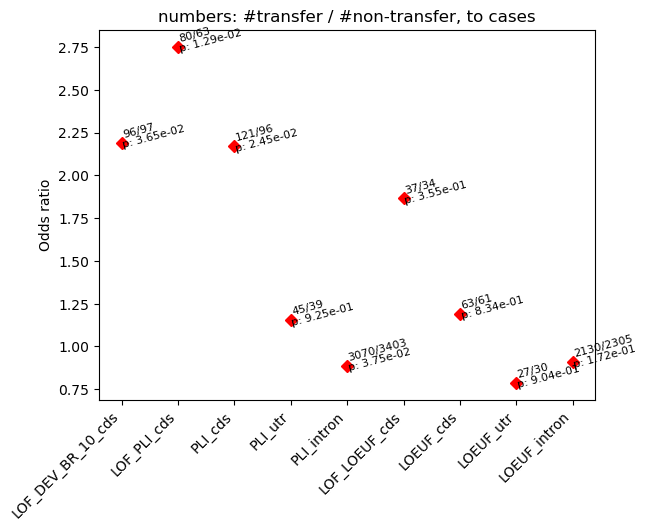

In [21]:
fts = lof_plus_consts
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

fig_name = dir_fig + 'transfer_enrich.png'
print(fig_name)
plot_tran_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.03, dx2=0.03)

In [16]:
def plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.02, dx2=0.02):
    # plot enrichment in biotypes
    #fts = biotypes
    #fig_name = 'odds_ratio_biotypes.png'
    ORs = []
    text_info = []
    chisq_ps = []
    for ft in fts:
        df_w = df_flt.loc[df_flt[f'X_{ft}'] == 1]
        df_wo = df_flt.loc[df_flt[f'X_{ft}'] == 0]
        print(f'SVs intersecting {ft}: {df_w.shape[0]}')
        
        n_w_ft_case = df_w[f'{flt_name}_CASE_NUM'].sum() + df_w['IL_SAMPLES_CASE_NUM'].sum()
        n_w_ft_control = df_w[f'{flt_name}_CONTROL_NUM'].sum() + df_w['IL_SAMPLES_CONTROL_NUM'].sum()
        n_wo_ft_case = df_wo[f'{flt_name}_CASE_NUM'].sum() + df_wo['IL_SAMPLES_CASE_NUM'].sum()
        n_wo_ft_control = df_wo[f'{flt_name}_CONTROL_NUM'].sum() + df_wo['IL_SAMPLES_CONTROL_NUM'].sum()
        text_info.append('/'.join([str(n_w_ft_case), str(n_w_ft_control)]))
        
        OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
        #print(f'n_w_ft_case: {n_w_ft_case}, n_w_ft_control: {n_w_ft_control}, n_wo_ft_case: {n_wo_ft_case}, n_wo_ft_control: {n_wo_ft_control}')#print(f'OR: {OR}')
        ORs.append(OR)
        ob = np.array([[n_w_ft_case, n_wo_ft_case], [n_w_ft_control, n_wo_ft_control]])
        try:
            chi2_stat, p_val, dof, expected = chi2_contingency(ob)
        except:
            p_val = np.nan
        chisq_ps.append(p_val)
        
    print('case/control chi-squared p-values:')
    print(' '.join(fts))
    print(' '.join([f'{x:.2e}' for x in chisq_ps]))
    #AR = 5
    plt.figure()
    plt.plot(range(0,len(fts)), ORs, 'Dr', label='All samples')
    for i in range(0,len(fts)):
        plt.text(i, ORs[i]+dx1, text_info[i], rotation=15, fontsize=8)
        plt.text(i, ORs[i]-dx2, f'p: {chisq_ps[i]:.2e}', rotation=15, fontsize=8)
    plt.xticks(range(0,len(fts)), fts, rotation=45, ha='right')
    plt.gca().set_aspect(AR)
    plt.ylabel('Odds ratio')
    plt.title('numbers: # cases / # controls, xing features')
    #plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    print(fig_name)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()
    plt.close()

hist_FDR_DD_utr.png


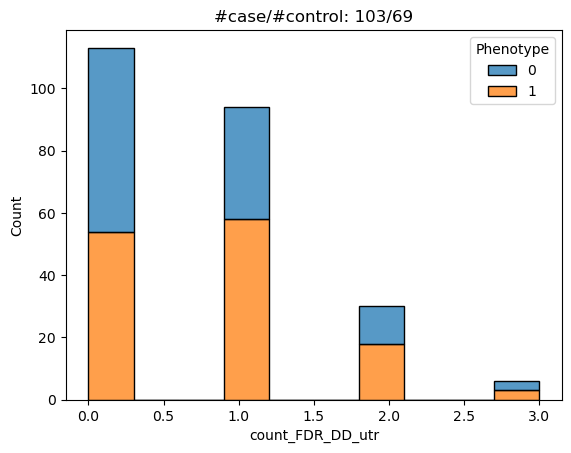

In [27]:
import seaborn as sb

ft = 'FDR_DD_utr'
df_main_copy = pd.DataFrame(df_main)
#df_main_copy[f'has_{ft}_var'] = df_main_copy[f'count_{ft}'] > 0
num_case = df_main_copy.loc[df_main_copy.Phenotype==1,f'count_{ft}'].sum()
num_control = df_main_copy.loc[df_main_copy.Phenotype==0,f'count_{ft}'].sum()

plt.figure()
#sb.scatterplot(data=df_main_copy, x='PC3', y='PC8', hue=f'has_{ft}_var')
sb.histplot(data=df_main_copy, x=f'count_{ft}', hue='Phenotype', multiple="stack")
plt.title(f'#case/#control: {num_case}/{num_control}')
fig_name = f'hist_{ft}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()

In [8]:
print(df.loc[df.SVTYPE.isin(['INS', 'DEL'])]['LOF'].sum())
print(df.loc[df.SVTYPE.isin(['DUP', 'INV'])]['LOF'].sum())
# chrM is filtered from chroms
print(df.LOF_DUP_INV.sum())

9483
821
821


hist_zero_cov_samples.png


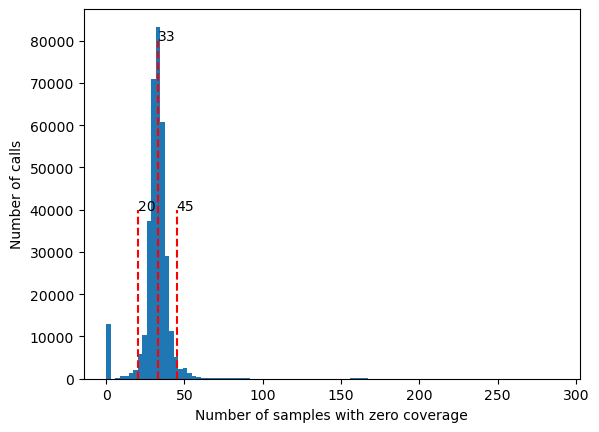

In [9]:
plt.figure()
plt.hist(df.NUM_ZERO_COV_SAMPLES, bins=100)

x_val = 45
y_val = 40000
plt.plot([x_val, x_val], [0, y_val], '--r')
plt.text(x_val, y_val, f'{x_val}')	

x_val = 20
y_val = 40000
plt.plot([x_val, x_val], [0, y_val], '--r')
plt.text(x_val, y_val, f'{x_val}')	

x_val = 33
y_val = 80000
plt.plot([x_val, x_val], [0, y_val], '--r')
plt.text(x_val, y_val, f'{x_val}')

plt.xlabel('Number of samples with zero coverage')
plt.ylabel('Number of calls')
fig_name = 'hist_zero_cov_samples.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

In [11]:
# look into what svtypes have more missing coverages
sv_counts = df.SVTYPE.value_counts()
print(sv_counts)
print(sv_counts.sum())

missing_sv_counts = df.loc[df.NUM_ZERO_COV_SAMPLES > 40].SVTYPE.value_counts()
print(missing_sv_counts)
print(missing_sv_counts.sum())

for svtype in sv_counts.index:
    print(svtype)
    sum_all = sv_counts.sum()
    print(f'fraction: {sv_counts[svtype] / sum_all}')
    sum_missing = missing_sv_counts.sum()
    print(f'missing fraction: {missing_sv_counts[svtype] / sum_missing}')

SVTYPE
DEL    119503
INS    117958
BND     87599
INV     13671
DUP      3235
Name: count, dtype: int64
341966
SVTYPE
INS    10856
BND     8285
DEL     6482
INV      916
DUP      123
Name: count, dtype: int64
26662
DEL
fraction: 0.34945871811817547
missing fraction: 0.24311754557047482
INS
fraction: 0.34494072510132584
missing fraction: 0.4071712549696197
BND
fraction: 0.2561628933870619
missing fraction: 0.31074187982897006
INV
fraction: 0.03997765859763836
missing fraction: 0.03435601230215288
DUP
fraction: 0.009460004795798413
missing fraction: 0.004613307328782537


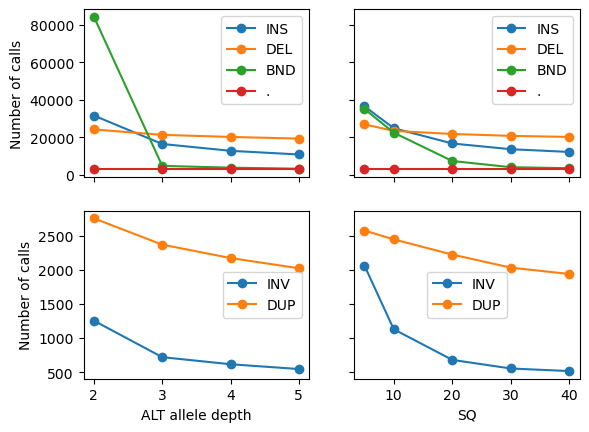

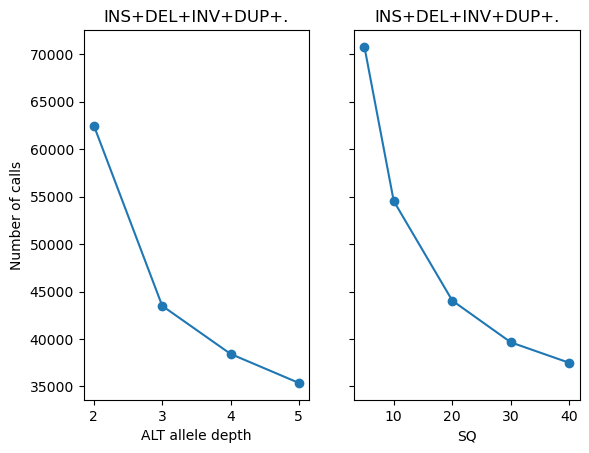

In [25]:
#N_ZERO_COV_THR = 40
ads = [2, 3, 4, 5]
qs = [5, 10, 20, 30, 40]
sv_counts_ad = []
sv_counts_q = []
for ad in [2, 3, 4, 5]:
    #print(f'++++++++++++ AD{ad} filter ++++++++++')
    this_df = df.loc[(df[f'NUM_AD{ad}_SAMPLES'] > 0) | (df['NUM_IL_SAMPLES'] > 0)]
    n_pass = this_df.shape[0]
    #print(f'AD{ad} filter, N pass: {n_pass}')
    sv_counts_ad.append(this_df.SVTYPE.value_counts())
    #print(sv_counts_ad[-1])
    
    #this_df_cov = df.loc[(df[f'NUM_AD{ad}_SAMPLES'] > 0) & (df['NUM_ZERO_COV_SAMPLES'] < N_ZERO_COV_THR)]
    #n_pass_cov = this_df_cov.shape[0]
    #print(this_df_cov.SVTYPE.value_counts())
    #print(f'AD{ad} filter with N_ZERO_COV < {N_ZERO_COV_THR}, N pass: {n_pass_cov}')
    #print()
    
for q in [5, 10, 20, 30, 40]:
    #print(f'++++++++++++ SQ{q} filter ++++++++++')
    this_df = df.loc[(df[f'NUM_SQ{q}_SAMPLES'] > 0) | (df['NUM_IL_SAMPLES'] > 0)]
    n_pass = this_df.shape[0]
    #print(f'SQ{q} filter, N pass: {n_pass}')
    sv_counts_q.append(this_df.SVTYPE.value_counts())
    #print(sv_counts_q[-1])
    
    #this_df_cov = df.loc[(df[f'NUM_SQ{q}_SAMPLES'] > 0) & (df['NUM_ZERO_COV_SAMPLES'] < N_ZERO_COV_THR)]
    #n_pass_cov = this_df_cov.shape[0]
    #print(f'SQ{q} filter with N_ZERO_COV < {N_ZERO_COV_THR}, N pass: {n_pass_cov}')
    #print(this_df_cov.SVTYPE.value_counts())
    #print()

###########################
fig, axs = plt.subplots(nrows=2, ncols=2, sharey='row', sharex='col')
svtypes_1 = ['INS', 'DEL', 'BND', '.']
svtypes_2 = ['INV', 'DUP']
for svtype in svtypes_1:
    axs[0, 0].plot(ads, [x[svtype] for x in sv_counts_ad], '-o', label=svtype)
for svtype in svtypes_1:
    axs[0, 1].plot(qs, [x[svtype] for x in sv_counts_q], '-o', label=svtype)
for svtype in svtypes_2:
    axs[1, 0].plot(ads, [x[svtype] for x in sv_counts_ad], '-o', label=svtype)
for svtype in svtypes_2:
    axs[1, 1].plot(qs, [x[svtype] for x in sv_counts_q], '-o', label=svtype)

axs[1, 0].set_xlabel('ALT allele depth')
axs[1, 1].set_xlabel('SQ')
axs[0, 0].set_ylabel('Number of calls')
axs[1, 0].set_ylabel('Number of calls')
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()

fig_name = 'filter_calls.png'
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

svtypes = ['INS', 'DEL', 'INV', 'DUP', '.']
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
ax1.plot(ads, [x[svtypes].sum() for x in sv_counts_ad], '-o')
ax2.plot(qs, [x[svtypes].sum() for x in sv_counts_q], '-o')
ax1.set_xlabel('ALT allele depth')
ax2.set_xlabel('SQ')
ax1.set_ylabel('Number of calls')
ax1.set_title('+'.join(svtypes))
ax2.set_title('+'.join(svtypes))
fig_name = 'filter_calls_total.png'
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

In [26]:
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']
df_flt = get_df_flt(df, flt_name, include_svtypes)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

total: (344736, 265)
filtered: (43240, 265)


len(samples_cases_list): 610887
len(samples_controls_list): 428891


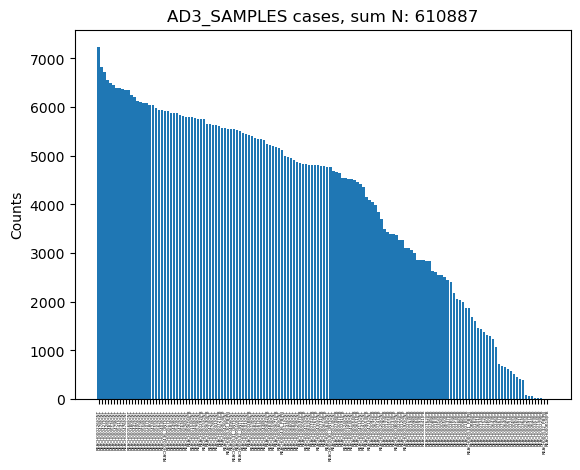

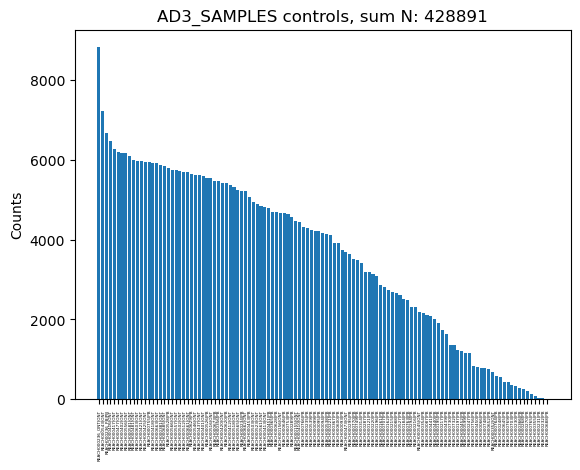

In [13]:
samples_cases_list = ['|'.join([y, plat_dict[y]]) for xs, cs in zip(df_flt[flt_name].str.split(',').tolist(), 
                                          df_flt[f'case_{flt_name}'].str.split(',').tolist()) 
                      for y, c in zip(xs, cs) if c=='Yes']

samples_controls_list = ['|'.join([y, plat_dict[y]]) for xs, cs in zip(df_flt[flt_name].str.split(',').tolist(), 
                                          df_flt[f'case_{flt_name}'].str.split(',').tolist()) 
                      for y, c in zip(xs, cs) if c=='No']

print('len(samples_cases_list):', len(samples_cases_list))
print('len(samples_controls_list):', len(samples_controls_list))

df_cases = pd.DataFrame({'samples': samples_cases_list})
case_count_nums = df_cases.value_counts().tolist()
case_count_samples = df_cases.value_counts().index.get_level_values(0).tolist()
#print('count cases:')
#print(case_count_nums)
#print(case_count_samples)

df_controls = pd.DataFrame({'samples': samples_controls_list})
control_count_nums = df_controls.value_counts().tolist()
control_count_samples = df_controls.value_counts().index.get_level_values(0).tolist()
#print('count controls:')
#print(control_count_nums)
#print(control_count_samples)

fig, ax = plt.subplots()
ax.bar(case_count_samples, case_count_nums)
ax.set_xticks(case_count_samples, case_count_samples, rotation=90, fontsize=3)
ax.set_aspect('auto')
plt.ylabel('Counts')
plt.title(f'{flt_name} cases, sum N: {df_cases.shape[0]}')
fig_name = f'sample_case_{flt_name}_counts_hist'
plt.savefig(fig_name+'.png', bbox_inches='tight')
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots()
ax.bar(control_count_samples, control_count_nums)
ax.set_xticks(control_count_samples, control_count_samples, rotation=90, fontsize=3)
ax.set_aspect('auto')
plt.ylabel('Counts')
plt.title(f'{flt_name} controls, sum N: {df_controls.shape[0]}')
fig_name = f'sample_control_{flt_name}_counts_hist'
plt.savefig(fig_name+'.png', bbox_inches='tight')
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()
plt.close()

total: (341966, 238)
filtered: (28716, 238)
SVs intersecting LOF_DEV_BR_10_cds: 53
SVs intersecting LOF_PLI_cds: 41
SVs intersecting PLI_cds: 78
SVs intersecting PLI_utr: 43
SVs intersecting PLI_intron: 2869
SVs intersecting LOF_LOEUF_cds: 22
SVs intersecting LOEUF_cds: 46
SVs intersecting LOEUF_utr: 32
SVs intersecting LOEUF_intron: 1956
case/control chi-squared p-values:
LOF_DEV_BR_10_cds LOF_PLI_cds PLI_cds PLI_utr PLI_intron LOF_LOEUF_cds LOEUF_cds LOEUF_utr LOEUF_intron
3.52e-02 4.10e-02 1.46e-01 9.59e-01 1.73e-01 8.31e-01 1.00e+00 8.04e-01 1.35e-01
odds_ratio_lof_plus_consts.png


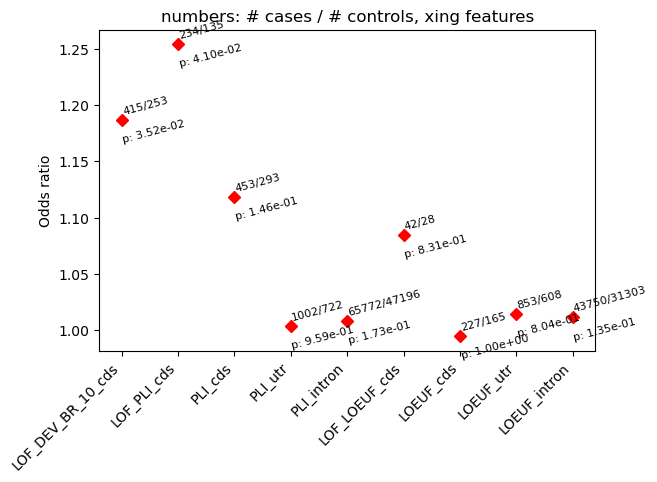

In [17]:
# plot enrichment in lof plus other constraints
fts = lof_plus_consts
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_lof_plus_consts.png'
flt_name = 'AD2_SAMPLES'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=20, dx1=0.005, dx2=0.02)
#plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.2, dx2=0.2)

total: (341966, 247)
filtered: (17055, 247)
SVs intersecting LOF_DEV_BR_10_cds: 50
SVs intersecting LOF_PLI_cds: 40
SVs intersecting PLI_cds: 76
SVs intersecting PLI_utr: 31
SVs intersecting PLI_intron: 1781
SVs intersecting LOF_LOEUF_cds: 22
SVs intersecting LOEUF_cds: 45
SVs intersecting LOEUF_utr: 22
SVs intersecting LOEUF_intron: 1237
case/control chi-squared p-values:
LOF_DEV_BR_10_cds LOF_PLI_cds PLI_cds PLI_utr PLI_intron LOF_LOEUF_cds LOEUF_cds LOEUF_utr LOEUF_intron
9.53e-03 7.05e-03 6.11e-02 7.67e-01 2.07e-01 8.77e-01 7.75e-01 6.14e-01 9.79e-01
odds_ratio_lof_plus_consts_freq05.png


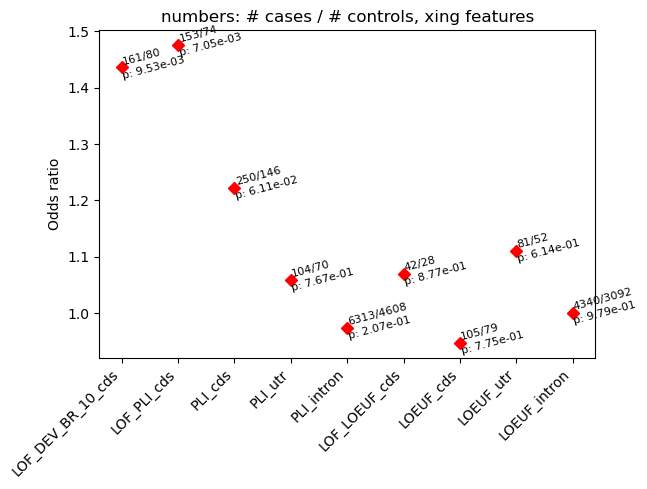

In [50]:
# plot enrichment in lof plus other constraints
fts = lof_plus_consts
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_lof_plus_consts_freq05.png'
flt_name = 'AD2_SAMPLES'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)
#plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.2, dx2=0.2)

total: (341966, 265)
filtered: (25534, 265)
SVs intersecting LOF_DEV_BR_10_cds: 87
SVs intersecting LOF_PLI_cds: 64
SVs intersecting PLI_cds: 116
SVs intersecting PLI_utr: 53
SVs intersecting PLI_intron: 2815
SVs intersecting LOF_LOEUF_cds: 37
SVs intersecting LOEUF_cds: 73
SVs intersecting LOEUF_utr: 39
SVs intersecting LOEUF_intron: 1955
case/control chi-squared p-values:
LOF_DEV_BR_10_cds LOF_PLI_cds PLI_cds PLI_utr PLI_intron LOF_LOEUF_cds LOEUF_cds LOEUF_utr LOEUF_intron
2.20e-02 7.53e-02 2.55e-01 5.96e-01 1.04e-01 7.51e-01 3.61e-01 5.91e-01 4.39e-01
odds_ratio_lof_plus_consts_freq05_addIL.png


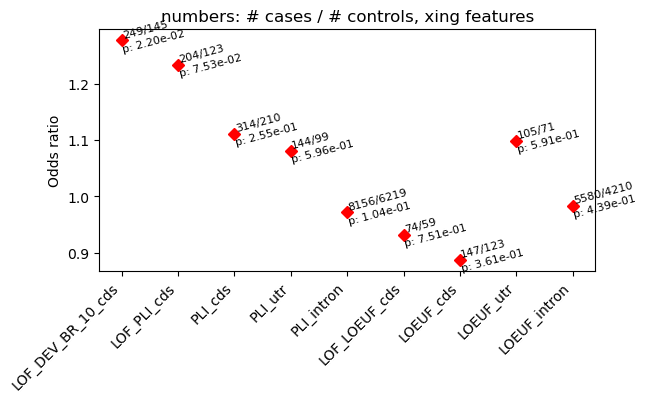

In [21]:
# plot enrichment in lof plus other constraints
fts = lof_plus_consts
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_lof_plus_consts_freq05_addIL.png'
flt_name = 'AD2_SAMPLES'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)
#plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.2, dx2=0.2)

total: (344736, 266)
filtered: (27669, 266)
SVs intersecting LOF_DEV_BR_10_cds: 87
SVs intersecting LOF_PLI_cds: 64
SVs intersecting PLI_cds: 116
SVs intersecting PLI_utr: 57
SVs intersecting PLI_intron: 3080
SVs intersecting LOF_LOEUF_cds: 37
SVs intersecting LOEUF_cds: 73
SVs intersecting LOEUF_utr: 40
SVs intersecting LOEUF_intron: 2138
case/control chi-squared p-values:
LOF_DEV_BR_10_cds LOF_PLI_cds PLI_cds PLI_utr PLI_intron LOF_LOEUF_cds LOEUF_cds LOEUF_utr LOEUF_intron
1.78e-02 6.42e-02 2.19e-01 5.59e-01 8.17e-02 7.87e-01 3.98e-01 5.13e-01 4.91e-01
odds_ratio_lof_plus_consts_freq05_addIL_new.png


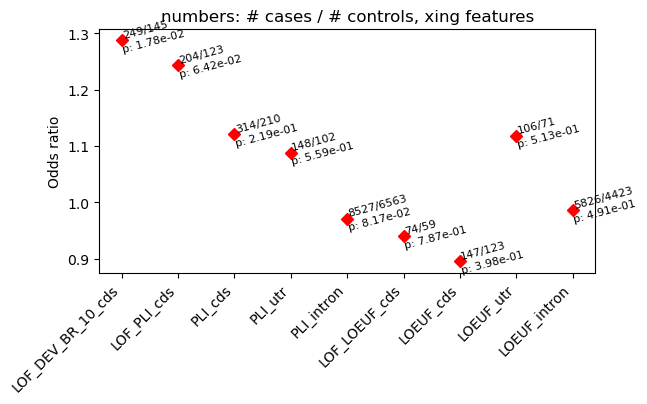

In [17]:
# plot enrichment in lof plus other constraints
fts = lof_plus_consts
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_lof_plus_consts_freq05_addIL_new.png'
flt_name = 'AD2_SAMPLES'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)
#plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.2, dx2=0.2)

total: (341966, 265)
filtered: (25534, 265)
SVs intersecting PLIp9_LOF_DEV_BR_10_cds: 47
SVs intersecting PLIp9_DEV_BR_GENE_10: 1299
SVs intersecting PLIp9_DEV_BR_GENE_10_cds: 71
SVs intersecting PLIp9_DEV_BR_GENE_10_utr: 29
SVs intersecting PLIp9_DEV_BR_GENE_10_intron: 1199
case/control chi-squared p-values:
PLIp9_LOF_DEV_BR_10_cds PLIp9_DEV_BR_GENE_10 PLIp9_DEV_BR_GENE_10_cds PLIp9_DEV_BR_GENE_10_utr PLIp9_DEV_BR_GENE_10_intron
1.71e-02 8.84e-01 9.95e-02 9.18e-01 7.93e-01
odds_ratio_lof_plus_consts5_freq05_addIL.png


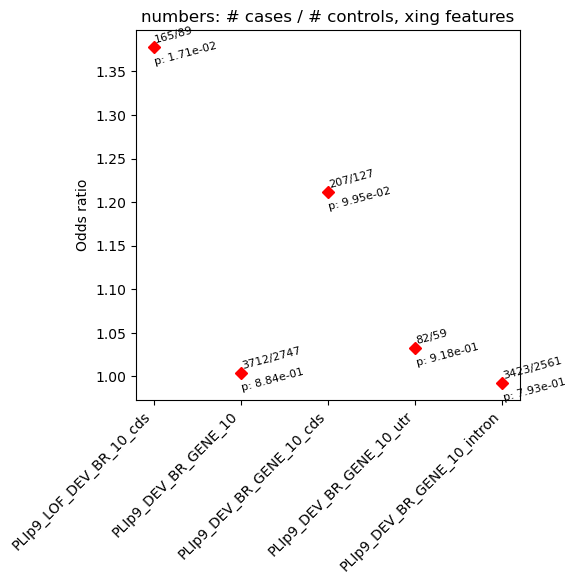

In [22]:
# plot enrichment in lof plus other constraints
fts = lof_plus_consts5
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_lof_plus_consts5_freq05_addIL.png'
flt_name = 'AD2_SAMPLES'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)
#plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.2, dx2=0.2)

total: (341966, 238)
filtered: (28716, 238)
SVs intersecting LOF_DEV_BR_10_cds: 53
SVs intersecting LOF_PLI_cds: 41
SVs intersecting PLI_cds: 78
SVs intersecting PLI_utr: 43
SVs intersecting PLI_intron: 2869
SVs intersecting LOF_LOWPLI_cds: 369
SVs intersecting LOWPLI_cds: 531
SVs intersecting LOWPLI_utr: 235
SVs intersecting LOWPLI_intron: 6442
case/control chi-squared p-values:
LOF_DEV_BR_10_cds LOF_PLI_cds PLI_cds PLI_utr PLI_intron LOF_LOWPLI_cds LOWPLI_cds LOWPLI_utr LOWPLI_intron
3.52e-02 4.10e-02 1.46e-01 9.59e-01 1.73e-01 4.47e-01 7.48e-01 9.85e-01 1.02e-01
odds_ratio_lof_plus_consts2.png


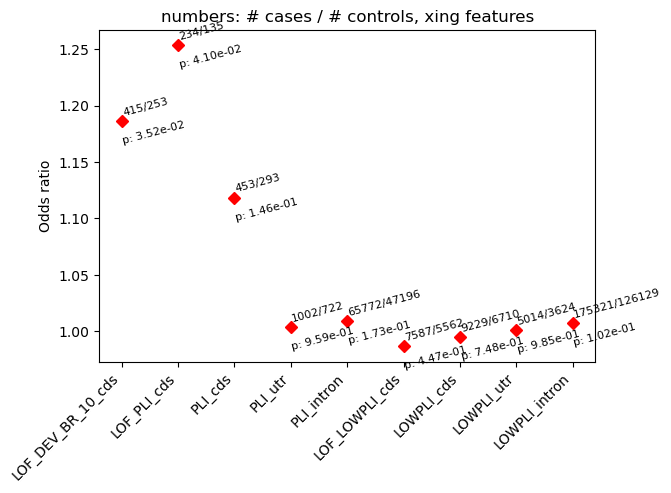

In [18]:
# plot enrichment in lof plus other constraints
fts = lof_plus_consts2
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_lof_plus_consts2.png'
flt_name = 'AD2_SAMPLES'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=20, dx1=0.005, dx2=0.02)
#plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.2, dx2=0.2)

total: (341966, 247)
filtered: (17055, 247)
SVs intersecting LOF_DEV_BR_10_cds: 50
SVs intersecting LOF_PLI_cds: 40
SVs intersecting PLI_cds: 76
SVs intersecting PLI_utr: 31
SVs intersecting PLI_intron: 1781
SVs intersecting LOF_LOWPLI_cds: 274
SVs intersecting LOWPLI_cds: 416
SVs intersecting LOWPLI_utr: 167
SVs intersecting LOWPLI_intron: 3849
case/control chi-squared p-values:
LOF_DEV_BR_10_cds LOF_PLI_cds PLI_cds PLI_utr PLI_intron LOF_LOWPLI_cds LOWPLI_cds LOWPLI_utr LOWPLI_intron
9.53e-03 7.05e-03 6.11e-02 7.67e-01 2.07e-01 3.32e-01 1.22e-02 6.67e-01 9.03e-01
odds_ratio_lof_plus_consts2_freq05.png


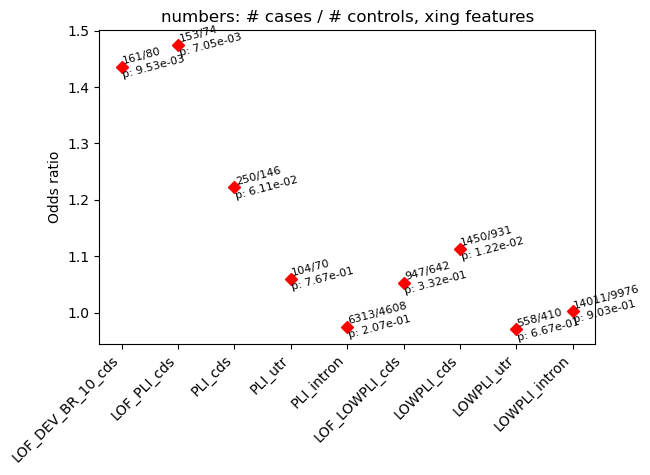

In [51]:
# plot enrichment in lof plus other constraints
fts = lof_plus_consts2
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_lof_plus_consts2_freq05.png'
flt_name = 'AD2_SAMPLES'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)
#plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.2, dx2=0.2)

total: (341966, 233)
filtered: (28716, 233)
SVs intersecting LOF_DEV_BR_50_cds: 9
SVs intersecting LOF_DEV_BR_40_cds: 11
SVs intersecting LOF_DEV_BR_30_cds: 16
SVs intersecting LOF_DEV_BR_20_cds: 36
SVs intersecting LOF_DEV_BR_10_cds: 53
case/control chi-squared p-values:
LOF_DEV_BR_50_cds LOF_DEV_BR_40_cds LOF_DEV_BR_30_cds LOF_DEV_BR_20_cds LOF_DEV_BR_10_cds
8.10e-01 1.00e+00 6.99e-01 3.32e-01 4.65e-02
odds_ratio_lof_dev_brain.png


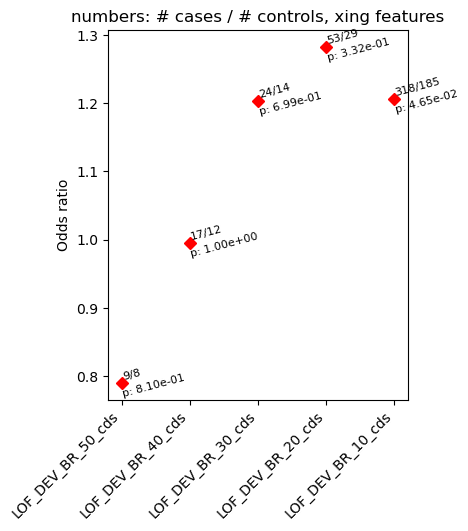

SVs intersecting DEV_BR_GENE_20: 1074
SVs intersecting DEV_BR_GENE_20_cds: 62
SVs intersecting DEV_BR_GENE_20_utr: 23
SVs intersecting DEV_BR_GENE_20_intron: 989
case/control chi-squared p-values:
DEV_BR_GENE_20 DEV_BR_GENE_20_cds DEV_BR_GENE_20_utr DEV_BR_GENE_20_intron
2.72e-01 5.83e-01 7.51e-01 3.17e-01
odds_ratio_dev_brain_20.png


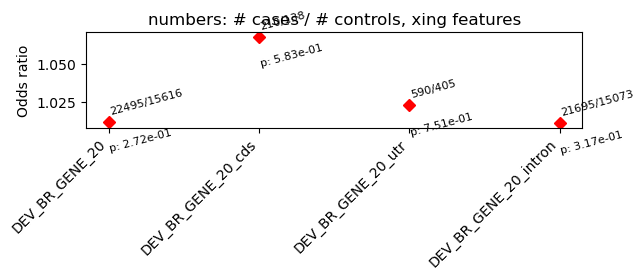

SVs intersecting DEV_BR_GENE_30: 545
SVs intersecting DEV_BR_GENE_30_cds: 33
SVs intersecting DEV_BR_GENE_30_utr: 16
SVs intersecting DEV_BR_GENE_30_intron: 496
case/control chi-squared p-values:
DEV_BR_GENE_30 DEV_BR_GENE_30_cds DEV_BR_GENE_30_utr DEV_BR_GENE_30_intron
3.53e-01 8.74e-01 8.38e-01 3.81e-01
odds_ratio_dev_brain_30.png


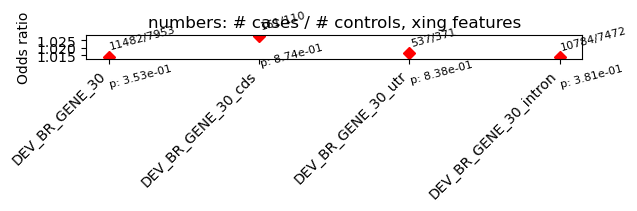

SVs intersecting DEV_BR_GENE_40: 303
SVs intersecting DEV_BR_GENE_40_cds: 23
SVs intersecting DEV_BR_GENE_40_utr: 12
SVs intersecting DEV_BR_GENE_40_intron: 268
case/control chi-squared p-values:
DEV_BR_GENE_40 DEV_BR_GENE_40_cds DEV_BR_GENE_40_utr DEV_BR_GENE_40_intron
7.41e-01 8.79e-01 8.25e-01 6.48e-01
odds_ratio_dev_brain_40.png


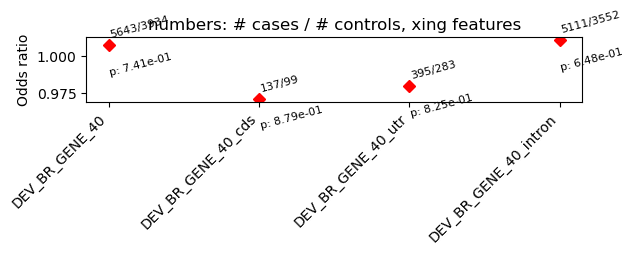

SVs intersecting DEV_BR_GENE_50: 226
SVs intersecting DEV_BR_GENE_50_cds: 18
SVs intersecting DEV_BR_GENE_50_utr: 12
SVs intersecting DEV_BR_GENE_50_intron: 196
case/control chi-squared p-values:
DEV_BR_GENE_50 DEV_BR_GENE_50_cds DEV_BR_GENE_50_utr DEV_BR_GENE_50_intron
7.24e-01 7.84e-01 8.25e-01 6.00e-01
odds_ratio_dev_brain_50.png


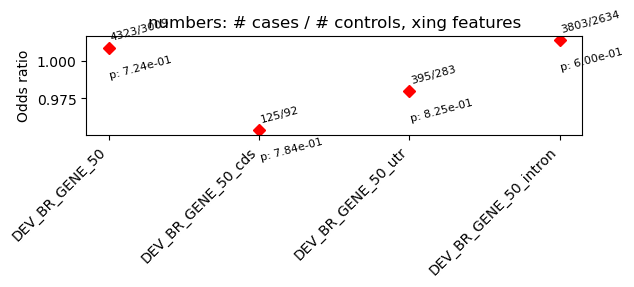

In [51]:
# plot enrichment in dev brain
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fts = lof_dev_br
fig_name = 'odds_ratio_lof_dev_brain.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)

fts = dev_br_20
fig_name = 'odds_ratio_dev_brain_20.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)

########## plot enrichment in features: fts ###########
fts = dev_br_30
fig_name = 'odds_ratio_dev_brain_30.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)

########## plot enrichment in features: fts ###########
fts = dev_br_40
fig_name = 'odds_ratio_dev_brain_40.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)

########## plot enrichment in features: fts ###########
fts = dev_br_50
fig_name = 'odds_ratio_dev_brain_50.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)

total: (341966, 204)
filtered: (28967, 204)
SVs intersecting lncRNA: 5418
SVs intersecting miRNA: 80
SVs intersecting misc_RNA: 126
SVs intersecting processed_transcript: 105
SVs intersecting snoRNA: 35
SVs intersecting snRNA: 142
SVs intersecting TEC: 247
SVs intersecting protein_coding: 10984
case/control chi-squared p-values:
lncRNA miRNA misc_RNA processed_transcript snoRNA snRNA TEC protein_coding
2.40e-01 1.98e-01 1.39e-01 8.17e-01 1.03e-01 3.56e-01 2.19e-127 3.57e-02
odds_ratio_biotypes.png


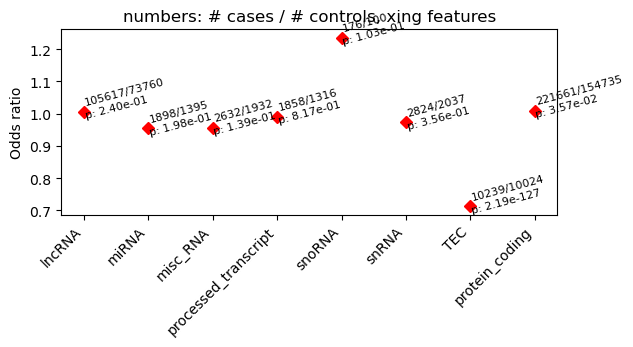

total: (341966, 204)
filtered: (653, 204)
SVs intersecting lncRNA: 286
SVs intersecting miRNA: 24
SVs intersecting misc_RNA: 27
SVs intersecting processed_transcript: 1
SVs intersecting snoRNA: 21
SVs intersecting snRNA: 43
SVs intersecting TEC: 26
SVs intersecting protein_coding: 510
case/control chi-squared p-values:
lncRNA miRNA misc_RNA processed_transcript snoRNA snRNA TEC protein_coding
3.27e-01 1.65e-01 3.30e-01 8.69e-01 1.74e-04 4.31e-02 2.73e-01 1.27e-05
odds_ratio_biotypes_LoF_DEL_INS_DUP_INV.png


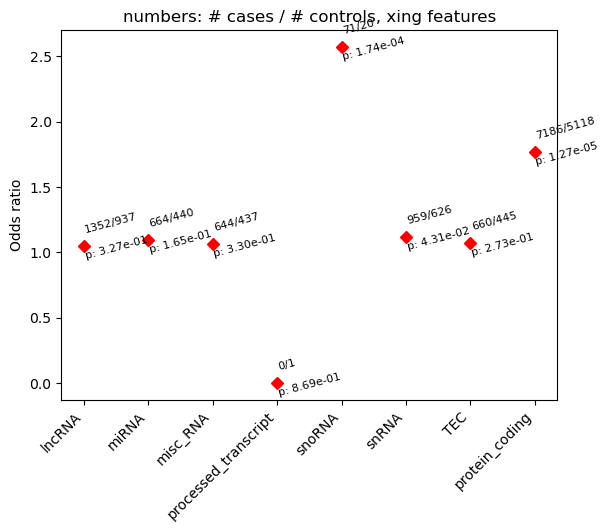

/tmp/ipykernel_1179707/319181823.py:19: RuntimeWarning: invalid value encountered in scalar divide
  OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


total: (341966, 204)
filtered: (592, 204)
SVs intersecting lncRNA: 255
SVs intersecting miRNA: 13
SVs intersecting misc_RNA: 16
SVs intersecting processed_transcript: 0
SVs intersecting snoRNA: 13
SVs intersecting snRNA: 24
SVs intersecting TEC: 12
SVs intersecting protein_coding: 449
case/control chi-squared p-values:
lncRNA miRNA misc_RNA processed_transcript snoRNA snRNA TEC protein_coding
2.78e-01 2.26e-01 2.75e-01 nan 1.23e-04 7.76e-02 2.41e-01 1.51e-05
odds_ratio_biotypes_LoF_DEL_INS.png


posx and posy should be finite values
posx and posy should be finite values


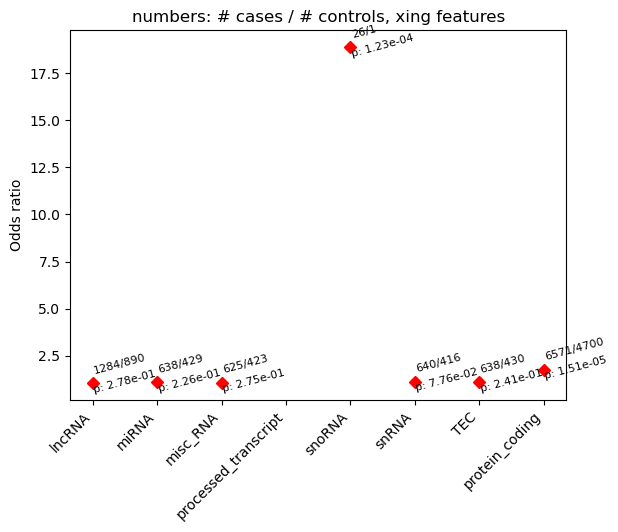

In [17]:
# plot enrichment in biotypes
fts = biotypes
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_biotypes.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=5, dx1=0.02, dx2=0.02)

# filter for main svtypes and quality and LoF in all svtypes
df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_biotypes_LoF_DEL_INS_DUP_INV.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.1, dx2=0.1)

# filter for main svtypes and quality and LoF
include_svtypes = ['INS', 'DEL']
df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_biotypes_LoF_DEL_INS.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.5, dx2=0.5)

total: (341966, 212)
filtered: (28716, 212)
SVs intersecting lncRNA: 5307
SVs intersecting miRNA: 46
SVs intersecting misc_RNA: 90
SVs intersecting processed_transcript: 104
SVs intersecting snoRNA: 22
SVs intersecting snRNA: 92
SVs intersecting TEC: 213
SVs intersecting protein_coding: 10873
case/control chi-squared p-values:
lncRNA miRNA misc_RNA processed_transcript snoRNA snRNA TEC protein_coding
1.90e-01 9.14e-01 5.54e-01 8.09e-01 2.15e-01 9.58e-01 1.00e-133 1.65e-02
odds_ratio_biotypes.png


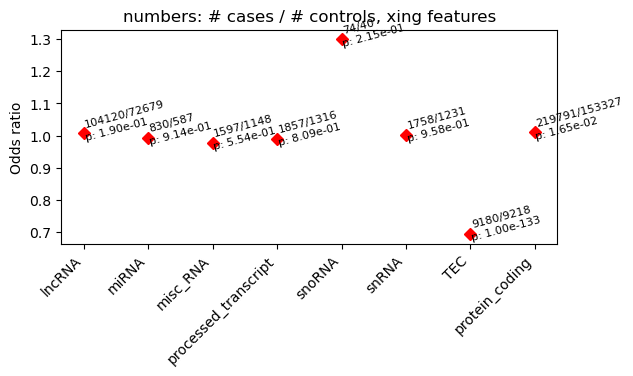

total: (341966, 212)
filtered: (585, 212)
SVs intersecting lncRNA: 253
SVs intersecting miRNA: 15
SVs intersecting misc_RNA: 20
SVs intersecting processed_transcript: 1
SVs intersecting snoRNA: 10
SVs intersecting snRNA: 26
SVs intersecting TEC: 18
SVs intersecting protein_coding: 443
case/control chi-squared p-values:
lncRNA miRNA misc_RNA processed_transcript snoRNA snRNA TEC protein_coding
4.95e-01 1.56e-01 3.70e-01 8.71e-01 3.85e-02 9.99e-02 2.80e-01 1.55e-05
odds_ratio_biotypes_LoF_DEL_INS_DUP_INV.png


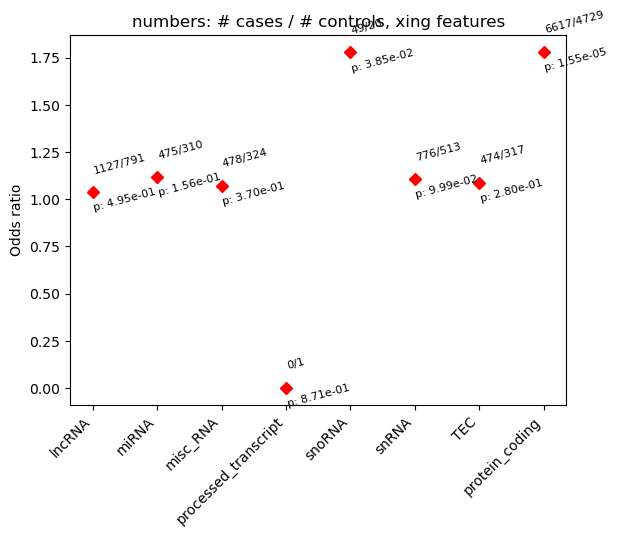

/tmp/ipykernel_2054737/319181823.py:19: RuntimeWarning: invalid value encountered in scalar divide
  OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


total: (341966, 212)
filtered: (533, 212)
SVs intersecting lncRNA: 229
SVs intersecting miRNA: 9
SVs intersecting misc_RNA: 13
SVs intersecting processed_transcript: 0
SVs intersecting snoRNA: 2
SVs intersecting snRNA: 11
SVs intersecting TEC: 8
SVs intersecting protein_coding: 391
case/control chi-squared p-values:
lncRNA miRNA misc_RNA processed_transcript snoRNA snRNA TEC protein_coding
4.32e-01 1.96e-01 2.66e-01 nan 5.84e-01 2.33e-01 2.11e-01 1.86e-05
odds_ratio_biotypes_LoF_DEL_INS.png


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


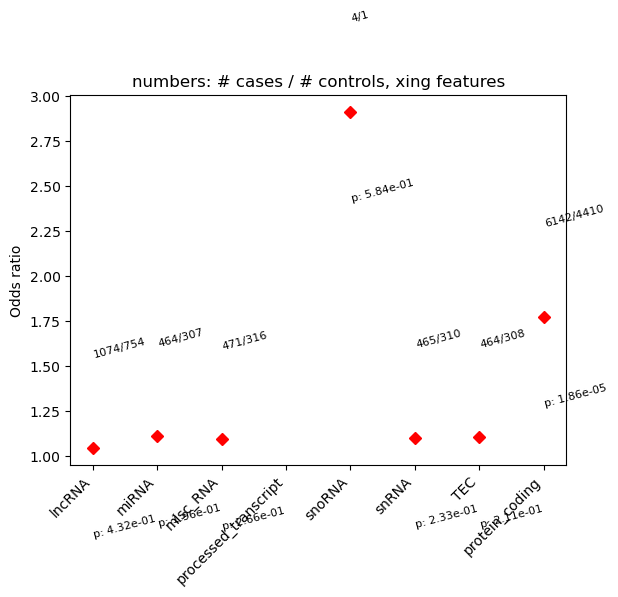

In [24]:
# plot enrichment in biotypes
fts = biotypes
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_biotypes.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=5, dx1=0.02, dx2=0.02)

# filter for main svtypes and quality and LoF in all svtypes
df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_biotypes_LoF_DEL_INS_DUP_INV.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.1, dx2=0.1)

# filter for main svtypes and quality and LoF
include_svtypes = ['INS', 'DEL']
df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_biotypes_LoF_DEL_INS.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.5, dx2=0.5)

total: (341966, 204)
filtered: (28967, 204)
SVs intersecting protein_coding_cds: 746
SVs intersecting protein_coding_utr: 298
SVs intersecting protein_coding_intron: 9940
SVs intersecting protein_coding_cds_pli: 98
SVs intersecting protein_coding_cds_loeuf: 65
SVs intersecting protein_coding_cds_fdr_asd: 8
SVs intersecting protein_coding_cds_fdr_dd: 12
SVs intersecting protein_coding_cds_fdr_ndd: 17
case/control chi-squared p-values:
protein_coding_cds protein_coding_utr protein_coding_intron protein_coding_cds_pli protein_coding_cds_loeuf protein_coding_cds_fdr_asd protein_coding_cds_fdr_dd protein_coding_cds_fdr_ndd
5.64e-02 8.71e-01 8.93e-03 9.26e-02 3.32e-01 1.00e+00 6.59e-01 4.04e-01
odds_ratio_pc_subsec.png


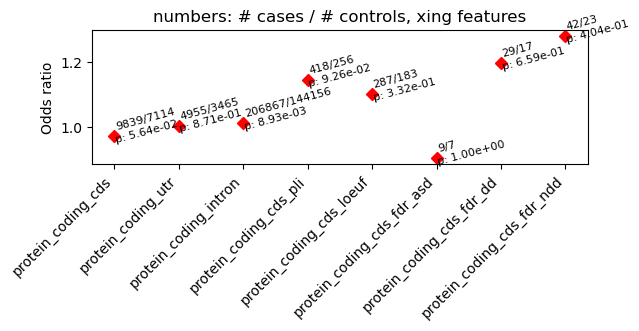

/tmp/ipykernel_1179707/319181823.py:19: RuntimeWarning: invalid value encountered in scalar divide
  OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


total: (341966, 204)
filtered: (653, 204)
SVs intersecting protein_coding_cds: 504
SVs intersecting protein_coding_utr: 6
SVs intersecting protein_coding_intron: 0
SVs intersecting protein_coding_cds_pli: 57
SVs intersecting protein_coding_cds_loeuf: 37
SVs intersecting protein_coding_cds_fdr_asd: 7
SVs intersecting protein_coding_cds_fdr_dd: 9
SVs intersecting protein_coding_cds_fdr_ndd: 13
case/control chi-squared p-values:
protein_coding_cds protein_coding_utr protein_coding_intron protein_coding_cds_pli protein_coding_cds_loeuf protein_coding_cds_fdr_asd protein_coding_cds_fdr_dd protein_coding_cds_fdr_ndd
1.75e-04 6.84e-02 nan 3.87e-03 4.82e-03 1.00e+00 5.06e-01 5.97e-01
odds_ratio_pc_subsec_LoF_DEL_INS_DUP_INV.png


posx and posy should be finite values
posx and posy should be finite values


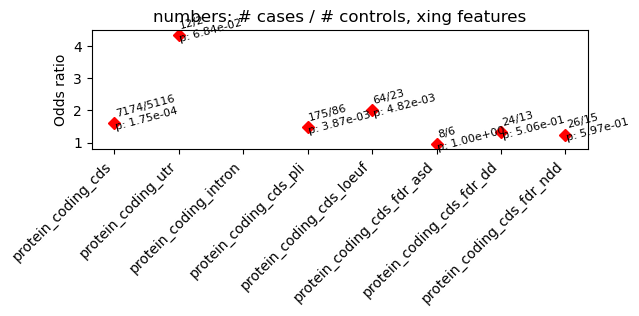

/tmp/ipykernel_1179707/319181823.py:19: RuntimeWarning: invalid value encountered in scalar divide
  OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


total: (341966, 204)
filtered: (592, 204)
SVs intersecting protein_coding_cds: 449
SVs intersecting protein_coding_utr: 0
SVs intersecting protein_coding_intron: 0
SVs intersecting protein_coding_cds_pli: 34
SVs intersecting protein_coding_cds_loeuf: 23
SVs intersecting protein_coding_cds_fdr_asd: 3
SVs intersecting protein_coding_cds_fdr_dd: 2
SVs intersecting protein_coding_cds_fdr_ndd: 4
case/control chi-squared p-values:
protein_coding_cds protein_coding_utr protein_coding_intron protein_coding_cds_pli protein_coding_cds_loeuf protein_coding_cds_fdr_asd protein_coding_cds_fdr_dd protein_coding_cds_fdr_ndd
1.51e-05 nan nan 1.33e-01 3.09e-03 7.79e-01 1.00e+00 4.06e-01
odds_ratio_pc_subsec_LoF_DEL_INS.png


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


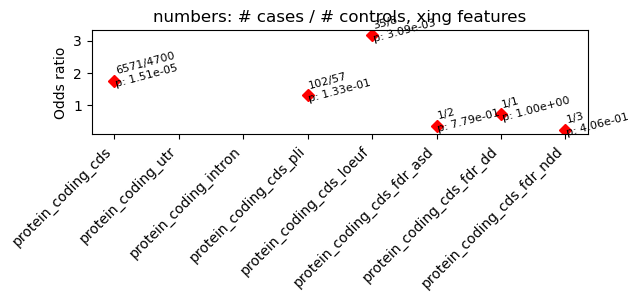

In [18]:
# plot enrichment in protein coding subsections
fts = pc_subsec
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_pc_subsec.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=5, dx1=0.02, dx2=0.02)

# filter for main svtypes and quality and LoF in all svtypes
df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_pc_subsec_LoF_DEL_INS_DUP_INV.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=.5, dx1=0.2, dx2=0.2)

# filter for main svtypes and quality and LoF
include_svtypes = ['INS', 'DEL']
df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_pc_subsec_LoF_DEL_INS.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=.5, dx1=0.2, dx2=0.2)

total: (341966, 204)
filtered: (28967, 204)
SVs intersecting PLI: 3010
SVs intersecting LOEUF: 2053
SVs intersecting FDR_ASD: 226
SVs intersecting FDR_DD: 525
SVs intersecting FDR_NDD: 715
case/control chi-squared p-values:
PLI LOEUF FDR_ASD FDR_DD FDR_NDD
2.39e-01 3.92e-01 7.97e-01 9.87e-01 4.99e-01
odds_ratio_constrains_1.png


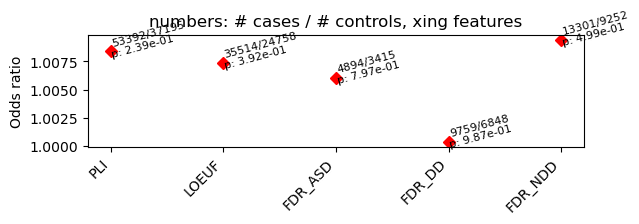

total: (341966, 204)
filtered: (653, 204)
SVs intersecting PLI: 57
SVs intersecting LOEUF: 37
SVs intersecting FDR_ASD: 7
SVs intersecting FDR_DD: 9
SVs intersecting FDR_NDD: 13
case/control chi-squared p-values:
PLI LOEUF FDR_ASD FDR_DD FDR_NDD
3.87e-03 4.82e-03 1.00e+00 5.06e-01 5.97e-01
odds_ratio_constrains_1_LoF_DEL_INS_DUP_INV.png


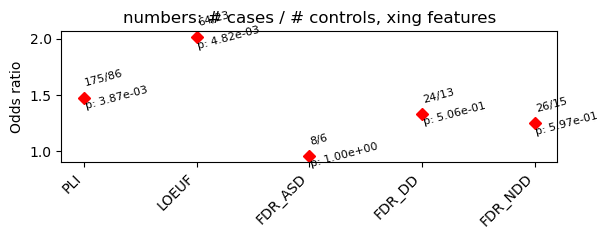

total: (341966, 204)
filtered: (592, 204)
SVs intersecting PLI: 34
SVs intersecting LOEUF: 23
SVs intersecting FDR_ASD: 3
SVs intersecting FDR_DD: 2
SVs intersecting FDR_NDD: 4
case/control chi-squared p-values:
PLI LOEUF FDR_ASD FDR_DD FDR_NDD
1.33e-01 3.09e-03 7.79e-01 1.00e+00 4.06e-01
odds_ratio_constrains_1_LoF_DEL_INS.png


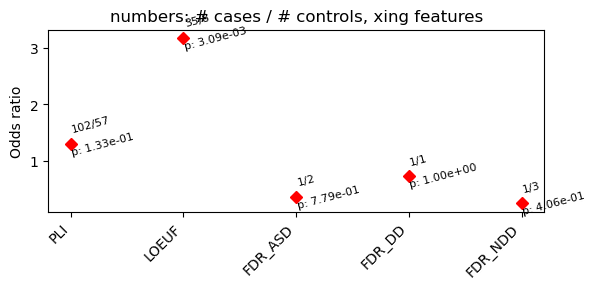

In [20]:
# plot enrichment in constrained annotations
fts = consts_1
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_constrains_1.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=100, dx1=0.0005, dx2=0.0005)

# filter for main svtypes and quality and LoF in all svtypes
df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_constrains_1_LoF_DEL_INS_DUP_INV.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=1, dx1=0.1, dx2=0.1)

# filter for main svtypes and quality and LoF
include_svtypes = ['INS', 'DEL']
df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_constrains_1_LoF_DEL_INS.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=.5, dx1=0.2, dx2=0.2)

total: (341966, 204)
filtered: (28967, 204)
SVs intersecting FB_PR: 811
SVs intersecting FB_ENH: 1636
SVs intersecting FANTOM: 1038
SVs intersecting GNOCCHI_1: 3981
SVs intersecting GNOCCHI_2: 1939
SVs intersecting GNOCCHI_3: 735
SVs intersecting GNOCCHI_4: 255
case/control chi-squared p-values:
FB_PR FB_ENH FANTOM GNOCCHI_1 GNOCCHI_2 GNOCCHI_3 GNOCCHI_4
5.25e-01 3.41e-01 1.80e-01 1.83e-01 4.19e-01 7.02e-01 5.53e-01
odds_ratio_constrains_2.png


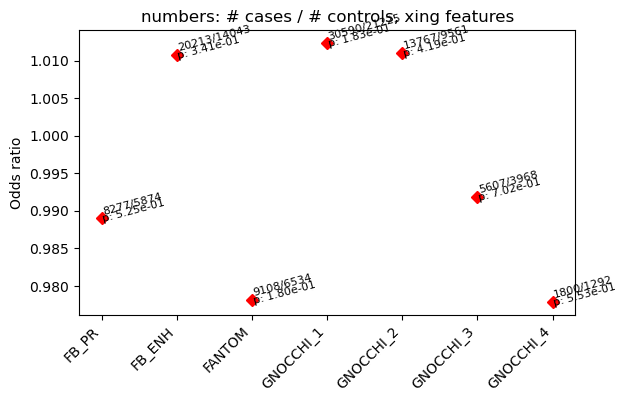

total: (341966, 204)
filtered: (653, 204)
SVs intersecting FB_PR: 251
SVs intersecting FB_ENH: 294
SVs intersecting FANTOM: 273
SVs intersecting GNOCCHI_1: 252
SVs intersecting GNOCCHI_2: 179
SVs intersecting GNOCCHI_3: 118
SVs intersecting GNOCCHI_4: 57
case/control chi-squared p-values:
FB_PR FB_ENH FANTOM GNOCCHI_1 GNOCCHI_2 GNOCCHI_3 GNOCCHI_4
9.05e-01 6.18e-01 8.26e-01 3.98e-01 9.80e-01 6.37e-01 5.70e-01
odds_ratio_constrains_2_LoF_DEL_INS_DUP_INV.png


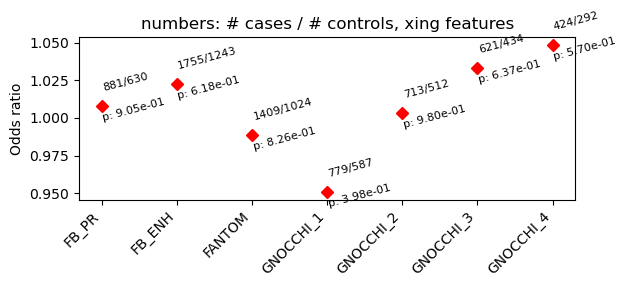

total: (341966, 204)
filtered: (592, 204)
SVs intersecting FB_PR: 214
SVs intersecting FB_ENH: 250
SVs intersecting FANTOM: 240
SVs intersecting GNOCCHI_1: 218
SVs intersecting GNOCCHI_2: 148
SVs intersecting GNOCCHI_3: 93
SVs intersecting GNOCCHI_4: 37
case/control chi-squared p-values:
FB_PR FB_ENH FANTOM GNOCCHI_1 GNOCCHI_2 GNOCCHI_3 GNOCCHI_4
9.13e-01 1.00e+00 4.51e-01 3.33e-01 9.67e-01 6.25e-01 8.38e-01
odds_ratio_constrains_2_LoF_DEL_INS.png


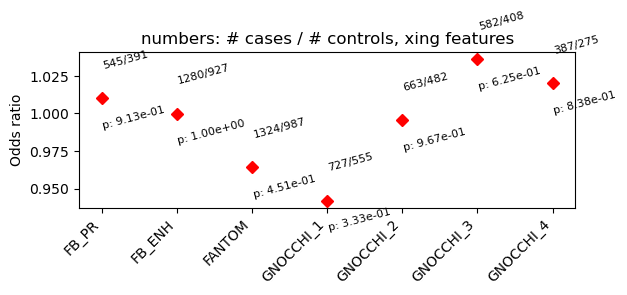

In [32]:
# plot enrichment in constrained annotations
fts = consts_2
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_constrains_2.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=100, dx1=0.0005, dx2=0.0005)

# filter for main svtypes and quality and LoF in all svtypes
df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
#df_flt = pd.DataFrame(get_df_flt(df, flt_name, include_svtypes, 'LOF'))
#df_flt['SVLEN'] = df_flt['SVLEN'].astype(int)
#df_flt = df_flt.loc[(df_flt.SVLEN < 10000) & (df_flt.SVLEN > -10000)]
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_constrains_2_LoF_DEL_INS_DUP_INV.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=20, dx1=0.01, dx2=0.01)

# filter for main svtypes and quality and LoF
include_svtypes = ['INS', 'DEL']
df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_constrains_2_LoF_DEL_INS.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=20, dx1=0.02, dx2=0.02)

total: (341966, 204)
filtered: (28967, 204)
SVs intersecting PLI_cds: 98
SVs intersecting PLI_utr: 43
SVs intersecting PLI_intron: 2869
SVs intersecting LOEUF_cds: 65
SVs intersecting LOEUF_utr: 32
SVs intersecting LOEUF_intron: 1956
case/control chi-squared p-values:
PLI_cds PLI_utr PLI_intron LOEUF_cds LOEUF_utr LOEUF_intron
9.26e-02 7.76e-01 3.21e-01 3.32e-01 8.13e-01 4.62e-01
odds_ratio_pli_loeuf_subset.png


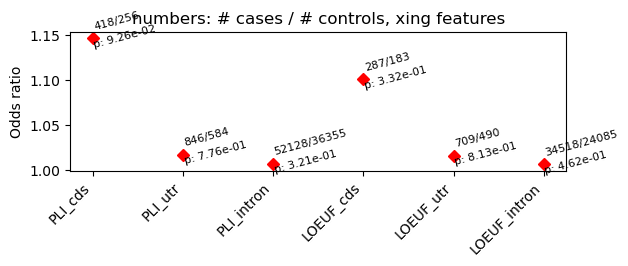

/tmp/ipykernel_1179707/319181823.py:19: RuntimeWarning: invalid value encountered in scalar divide
  OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite

total: (341966, 204)
filtered: (653, 204)
SVs intersecting PLI_cds: 57
SVs intersecting PLI_utr: 0
SVs intersecting PLI_intron: 0
SVs intersecting LOEUF_cds: 37
SVs intersecting LOEUF_utr: 0
SVs intersecting LOEUF_intron: 0
case/control chi-squared p-values:
PLI_cds PLI_utr PLI_intron LOEUF_cds LOEUF_utr LOEUF_intron
3.87e-03 nan nan 4.82e-03 nan nan
odds_ratio_pli_loeuf_subset_LoF_DEL_INS_DUP_INV.png


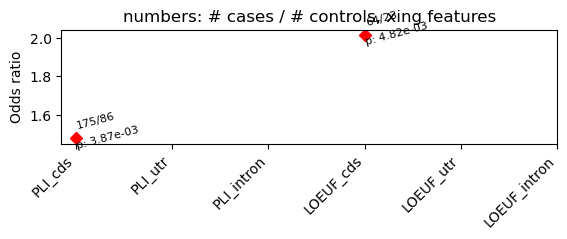

/tmp/ipykernel_1179707/319181823.py:19: RuntimeWarning: invalid value encountered in scalar divide
  OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite

total: (341966, 204)
filtered: (592, 204)
SVs intersecting PLI_cds: 34
SVs intersecting PLI_utr: 0
SVs intersecting PLI_intron: 0
SVs intersecting LOEUF_cds: 23
SVs intersecting LOEUF_utr: 0
SVs intersecting LOEUF_intron: 0
case/control chi-squared p-values:
PLI_cds PLI_utr PLI_intron LOEUF_cds LOEUF_utr LOEUF_intron
1.33e-01 nan nan 3.09e-03 nan nan
odds_ratio_pli_loeuf_subset_LoF_DEL_INS.png


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


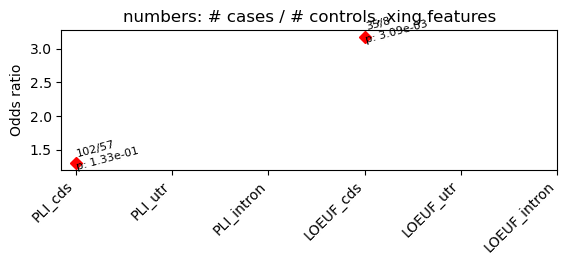

In [42]:
# plot enrichment in constrained subsets
fts = consts_subsec_1
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_pli_loeuf_subset.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.01, dx2=0.01)

# filter for main svtypes and quality and LoF in all svtypes
df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_pli_loeuf_subset_LoF_DEL_INS_DUP_INV.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=2, dx1=0.05, dx2=0.05)

# filter for main svtypes and quality and LoF
include_svtypes = ['INS', 'DEL']
df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_pli_loeuf_subset_LoF_DEL_INS.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=.7, dx1=0.1, dx2=0.1)

total: (341966, 204)
filtered: (28967, 204)
SVs intersecting FDR_ASD_cds: 8
SVs intersecting FDR_ASD_utr: 2
SVs intersecting FDR_ASD_intron: 216
SVs intersecting FDR_DD_cds: 12
SVs intersecting FDR_DD_utr: 8
SVs intersecting FDR_DD_intron: 505
SVs intersecting FDR_NDD_cds: 17
SVs intersecting FDR_NDD_utr: 10
SVs intersecting FDR_NDD_intron: 688
case/control chi-squared p-values:
FDR_ASD_cds FDR_ASD_utr FDR_ASD_intron FDR_DD_cds FDR_DD_utr FDR_DD_intron FDR_NDD_cds FDR_NDD_utr FDR_NDD_intron
1.00e+00 1.00e+00 7.98e-01 6.59e-01 6.50e-01 9.60e-01 4.04e-01 6.62e-01 5.50e-01
odds_ratio_fdr_subset.png


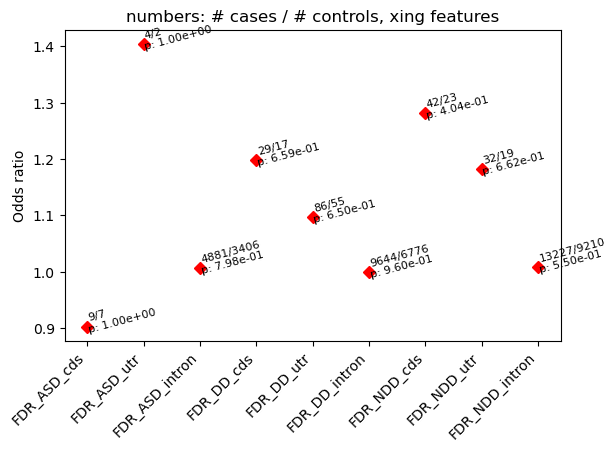

/tmp/ipykernel_1179707/319181823.py:19: RuntimeWarning: invalid value encountered in scalar divide
  OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite

total: (341966, 204)
filtered: (653, 204)
SVs intersecting FDR_ASD_cds: 7
SVs intersecting FDR_ASD_utr: 0
SVs intersecting FDR_ASD_intron: 0
SVs intersecting FDR_DD_cds: 9
SVs intersecting FDR_DD_utr: 0
SVs intersecting FDR_DD_intron: 0
SVs intersecting FDR_NDD_cds: 13
SVs intersecting FDR_NDD_utr: 0
SVs intersecting FDR_NDD_intron: 0
case/control chi-squared p-values:
FDR_ASD_cds FDR_ASD_utr FDR_ASD_intron FDR_DD_cds FDR_DD_utr FDR_DD_intron FDR_NDD_cds FDR_NDD_utr FDR_NDD_intron
1.00e+00 nan nan 5.06e-01 nan nan 5.97e-01 nan nan
odds_ratio_fdr_subset_LoF_DEL_INS_DUP_INV.png


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


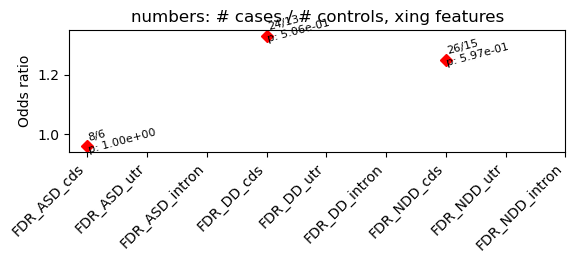

/tmp/ipykernel_1179707/319181823.py:19: RuntimeWarning: invalid value encountered in scalar divide
  OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite

total: (341966, 204)
filtered: (592, 204)
SVs intersecting FDR_ASD_cds: 3
SVs intersecting FDR_ASD_utr: 0
SVs intersecting FDR_ASD_intron: 0
SVs intersecting FDR_DD_cds: 2
SVs intersecting FDR_DD_utr: 0
SVs intersecting FDR_DD_intron: 0
SVs intersecting FDR_NDD_cds: 4
SVs intersecting FDR_NDD_utr: 0
SVs intersecting FDR_NDD_intron: 0
case/control chi-squared p-values:
FDR_ASD_cds FDR_ASD_utr FDR_ASD_intron FDR_DD_cds FDR_DD_utr FDR_DD_intron FDR_NDD_cds FDR_NDD_utr FDR_NDD_intron
7.79e-01 nan nan 1.00e+00 nan nan 4.06e-01 nan nan
odds_ratio_fdr_subset_LoF_DEL_INS.png


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


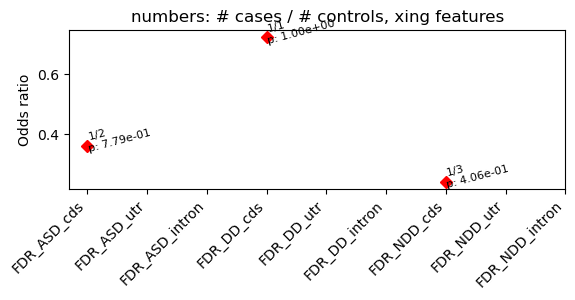

In [47]:
# plot enrichment in constrained subsets
fts = consts_subsec_2
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = 'odds_ratio_fdr_subset.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.01, dx2=0.01)

# filter for main svtypes and quality and LoF in all svtypes
#df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
#print(f'total: {df.shape}')
#print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
#fig_name = 'odds_ratio_fdr_subset_LoF_DEL_INS_DUP_INV.png'
#plot_enrich(df_flt, fts, flt_name, fig_name, AR=5, dx1=0.02, dx2=0.02)

# filter for main svtypes and quality and LoF
#include_svtypes = ['INS', 'DEL']
#df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
#print(f'total: {df.shape}')
#print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
#fig_name = 'odds_ratio_fdr_subset_LoF_DEL_INS.png'
#plot_enrich(df_flt, fts, flt_name, fig_name, AR=5, dx1=0.02, dx2=0.02)

total: (341966, 247)
filtered: (17055, 247)
SVs intersecting FDR_ASD_cds: 7
SVs intersecting FDR_ASD_utr: 2
SVs intersecting FDR_ASD_intron: 126
SVs intersecting FDR_DD_cds: 8
SVs intersecting FDR_DD_utr: 7
SVs intersecting FDR_DD_intron: 311
SVs intersecting FDR_NDD_cds: 12
SVs intersecting FDR_NDD_utr: 10
SVs intersecting FDR_NDD_intron: 418
case/control chi-squared p-values:
FDR_ASD_cds FDR_ASD_utr FDR_ASD_intron FDR_DD_cds FDR_DD_utr FDR_DD_intron FDR_NDD_cds FDR_NDD_utr FDR_NDD_intron
9.19e-01 1.00e+00 1.66e-01 9.24e-01 7.59e-01 6.97e-01 7.85e-01 6.17e-01 9.14e-01
odds_ratio_fdr_subset_freq05.png


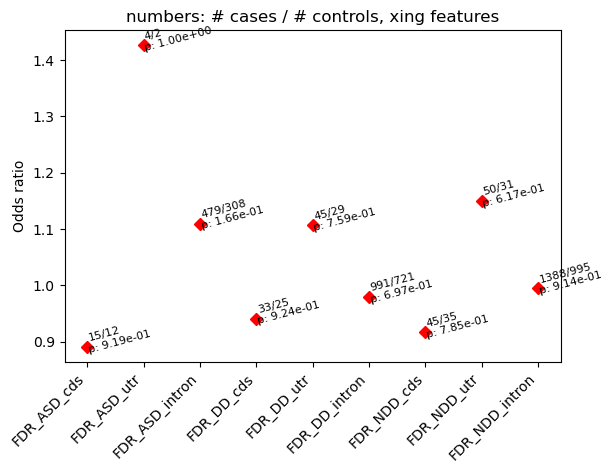

In [52]:
# plot enrichment in constrained subsets
fts = consts_subsec_2
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
flt_name = 'AD2_SAMPLES'
fig_name = 'odds_ratio_fdr_subset_freq05.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.01, dx2=0.01)

# filter for main svtypes and quality and LoF in all svtypes
#df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
#print(f'total: {df.shape}')
#print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
#fig_name = 'odds_ratio_fdr_subset_LoF_DEL_INS_DUP_INV.png'
#plot_enrich(df_flt, fts, flt_name, fig_name, AR=5, dx1=0.02, dx2=0.02)

# filter for main svtypes and quality and LoF
#include_svtypes = ['INS', 'DEL']
#df_flt = get_df_flt(df, flt_name, include_svtypes, 'LOF')
#print(f'total: {df.shape}')
#print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
#fig_name = 'odds_ratio_fdr_subset_LoF_DEL_INS.png'
#plot_enrich(df_flt, fts, flt_name, fig_name, AR=5, dx1=0.02, dx2=0.02)